# Testing VPU & Signal Reconstruction

The aim of this blog post is to test that we can correctly reconstruct a simple signal. And also to better understand the data of each stage.

## Test Binary Vectors
Let's test first by randomly selecting between [0, 0] and [1, 1] vectors.

In [1]:
from src.var_processor.vpu import VPU, VPUBinary
import random
import numpy as np

In [2]:
random.random()

0.5500362234995418

In [3]:
def rand_same(size=2):
    a = np.empty([size, 1])
    a.fill(np.random.randint(size))
    return a

In [4]:
def rand_diff(size=2):
    a = np.zeros([size, 1])
    index = np.random.randint(size)
    a[index] = 1
    return a

In [5]:
print(rand_same(), rand_same().shape)

[[1.]
 [1.]] (2, 1)


In [6]:
print(rand_diff(), rand_diff().shape)

[[1.]
 [0.]] (2, 1)


In [7]:
vpu = VPU(2)
print(vpu.cu.covariance, vpu.pi.ev)
for _ in range(0, 1000):
    vpu.update_cov(rand_same())
    vpu.pi.iterate(cov=vpu.cu.covariance)
print(vpu.cu.covariance, vpu.pi.ev)

[[0. 0.]
 [0. 0.]] [[0.19021269]
 [0.98174291]]
[[0.2468129 0.2468129]
 [0.2468129 0.2468129]] [[0.70710678]
 [0.70710678]]


In [8]:
print(vpu.pi.eigenvalue, vpu.pi.eigenvector)

[[0.4936258]] [[0.70710678]
 [0.70710678]]


In [9]:
np.sqrt(vpu.pi.eigenvalue)

array([[0.70258508]])

In [10]:
np.dot(vpu.pi.eigenvector, np.sqrt(vpu.pi.eigenvalue))

array([[0.49680268],
       [0.49680268]])

Does the above expression thus give you something to do with the probability for the vector?

In [11]:
np.dot(vpu.pi.eigenvector, np.sqrt(vpu.pi.eigenvalue))+vpu.cu.mean

array([[1.00780268],
       [1.00780268]])

We can use this to same with x = 1 or 0? Or x = -1, or 1?

In [12]:
print(
    np.dot(vpu.pi.eigenvector, np.sqrt(vpu.pi.eigenvalue))+vpu.cu.mean,
    -1*np.dot(vpu.pi.eigenvector, np.sqrt(vpu.pi.eigenvalue))+vpu.cu.mean
)

[[1.00780268]
 [1.00780268]] [[0.01419732]
 [0.01419732]]


Yes - x = -1 or 1 or random value within this range.

In [13]:
# Adapt to test

vpu = VPU(2)
for _ in range(0, 1000):
    vpu.update_cov(rand_same())
    vpu.pi.iterate(cov=vpu.cu.covariance)
# Check all values of covariance matrix are the same
print(vpu.cu.covariance, vpu.cu.covariance[0])
assert np.allclose(vpu.cu.covariance, vpu.cu.covariance[0])
# Check eigenvector has values of root 2
print(vpu.pi.eigenvector, 1/np.sqrt(2))
assert np.allclose(vpu.pi.eigenvector, 1/np.sqrt(2))
sample_1 = np.dot(
        vpu.pi.eigenvector, np.sqrt(vpu.pi.eigenvalue))+vpu.cu.mean
sample_minus1 = -1*np.dot(
        vpu.pi.eigenvector, np.sqrt(vpu.pi.eigenvalue))+vpu.cu.mean
assert np.allclose(sample_1, np.array([1, 1]), rtol=0.05, atol=0.05)
assert np.allclose(sample_minus1, np.array([0, 0]), rtol=0.05, atol=0.05)

[[0.24677039 0.24677039]
 [0.24677039 0.24677039]] [0.24677039 0.24677039]
[[0.70710678]
 [0.70710678]] 0.7071067811865475


In [14]:
1/np.sqrt(2)

0.7071067811865475

In [15]:
vpu = VPU(2)
print(vpu.cu.covariance, vpu.pi.ev, sep="\n", end="\n\n")
for _ in range(0, 1000):
    vpu.update_cov(rand_diff())
    vpu.pi.iterate(cov=vpu.cu.covariance)
print(vpu.cu.covariance, vpu.pi.ev, vpu.pi.eigenvalue, sep="\n", end="\n\n")
print(
    vpu.cu.mean,
    np.dot(vpu.pi.eigenvector, np.sqrt(vpu.pi.eigenvalue)), 
    np.dot(vpu.pi.eigenvector, np.sqrt(vpu.pi.eigenvalue))+vpu.cu.mean,
    sep="\n",
    end="\n\n"
)

[[0. 0.]
 [0. 0.]]
[[0.1604938 ]
 [0.98703685]]

[[ 0.24676733 -0.24676733]
 [-0.24676733  0.24676733]]
[[-0.70710678]
 [ 0.70710678]]
[[0.49353466]]

[[0.512]
 [0.488]]
[[-0.49675681]
 [ 0.49675681]]
[[0.01524319]
 [0.98475681]]



How would we get a sample of [0, 1] if x = 0 then we just have mean. Ah - x needs to be between -1 and 1.

In [16]:
# Forward Pass
a = rand_diff()
print(a, np.dot(vpu.pi.eigenvector.T, a))

[[1.]
 [0.]] [[-0.70710678]]


In [17]:
np.dot(vpu.pi.eigenvector, np.sqrt(vpu.pi.eigenvalue))+vpu.cu.mean

array([[0.01524319],
       [0.98475681]])

In [18]:
-1*np.dot(vpu.pi.eigenvector, np.sqrt(vpu.pi.eigenvalue))+vpu.cu.mean

array([[ 1.00875681],
       [-0.00875681]])

In [19]:
# Adapt to test

vpu = VPU(2)
for _ in range(0, 1000):
    vpu.update_cov(rand_diff())
    vpu.pi.iterate(cov=vpu.cu.covariance)
# Check diagonal values of covariance matrix are the same
# Use https://docs.scipy.org/doc/numpy/reference/generated/numpy.diagonal.html
print(vpu.cu.covariance[0], -1*vpu.cu.covariance[-1])
assert np.allclose(vpu.cu.covariance[0], -1*vpu.cu.covariance[-1])
# Check eigenvector has values of root 2
print(vpu.pi.eigenvector, 1/np.sqrt(2))
assert np.allclose(np.abs(vpu.pi.eigenvector), 1/np.sqrt(2))
# Check different signs
assert np.allclose(vpu.pi.eigenvector[0], -1*vpu.pi.eigenvector[1])
sample_1 = np.dot(
        vpu.pi.eigenvector, np.sqrt(vpu.pi.eigenvalue))+vpu.cu.mean
sample_minus1 = -1*np.dot(
        vpu.pi.eigenvector, np.sqrt(vpu.pi.eigenvalue))+vpu.cu.mean
print(sample_1, np.flipud(sample_minus1))
assert np.allclose(sample_1, np.flipud(sample_minus1), rtol=0.1, atol=0.1)
print(f"Eigenvalue = {vpu.pi.eigenvalue} - square root = {np.sqrt(vpu.pi.eigenvalue)}")

[ 0.24708701 -0.24708701] [ 0.24708701 -0.24708701]
[[ 0.70710678]
 [-0.70710678]] 0.7071067811865475
[[0.98807848]
 [0.01192152]] [[ 1.00607848]
 [-0.00607848]]
Eigenvalue = [[0.49417403]] - square root = [[0.70297512]]


In [20]:
sample_1 = np.dot(
        vpu.pi.eigenvector, np.sqrt(2))
sample_minus1 = -1*np.dot(
        vpu.pi.eigenvector, np.sqrt(2))
print(sample_1, sample_minus1)

[[ 1.]
 [-1.]] [[-1.]
 [ 1.]]


Let's try some with L = 3.

In [21]:
vpu = VPU(3)
for _ in range(0, 1000):
    vpu.update_cov(rand_same(size=3))
    vpu.pi.iterate(cov=vpu.cu.covariance)
# Check all values of covariance matrix are the same
print(vpu.cu.covariance, vpu.cu.covariance[0])
assert np.allclose(vpu.cu.covariance, vpu.cu.covariance[0])
# Check eigenvector has values of root 2
print(vpu.pi.eigenvector, 1/np.sqrt(3))
assert np.allclose(vpu.pi.eigenvector, 1/np.sqrt(3))

[[0.67591868 0.67591868 0.67591868]
 [0.67591868 0.67591868 0.67591868]
 [0.67591868 0.67591868 0.67591868]] [0.67591868 0.67591868 0.67591868]
[[0.57735027]
 [0.57735027]
 [0.57735027]] 0.5773502691896258


In [22]:
print(f"Eigenvalue = {vpu.pi.eigenvalue} - square root = {np.sqrt(vpu.pi.eigenvalue)}")

Eigenvalue = [[2.02775605]] - square root = [[1.423993]]


In [23]:
vpu.pi.eigenvector*np.sqrt(3)

array([[1.],
       [1.],
       [1.]])

In [24]:
sample_1 = np.dot(
        vpu.pi.eigenvector, np.sqrt(vpu.pi.eigenvalue))
sample_minus1 = -1*np.dot(
        vpu.pi.eigenvector, np.sqrt(vpu.pi.eigenvalue))
print(sample_1, sample_minus1)

[[0.82214274]
 [0.82214274]
 [0.82214274]] [[-0.82214274]
 [-0.82214274]
 [-0.82214274]]


In [25]:
sample_1 = np.dot(
        vpu.pi.eigenvector, np.sqrt(3))
sample_minus1 = -1*np.dot(
        vpu.pi.eigenvector, np.sqrt(3))
print(sample_1, sample_minus1)

[[1.]
 [1.]
 [1.]] [[-1.]
 [-1.]
 [-1.]]


In [26]:
vpu = VPU(3)
for _ in range(0, 1000):
    vpu.update_cov(rand_diff(size=3))
    vpu.pi.iterate(cov=vpu.cu.covariance)
# Check all values of covariance matrix are the same
print(vpu.cu.covariance[0], -1*vpu.cu.covariance[-1])
# assert np.allclose(vpu.cu.covariance[0], -1*vpu.cu.covariance[-1])
# Check eigenvector has values of root 2
print(vpu.pi.eigenvector, 1/np.sqrt(3))
# assert np.allclose(np.abs(vpu.pi.eigenvector), 1/np.sqrt(3))
# Check different signs
# assert np.allclose(vpu.pi.eigenvector[0], -1*vpu.pi.eigenvector[1])
sample_1 = np.dot(
        vpu.pi.eigenvector, np.sqrt(vpu.pi.eigenvalue))+vpu.cu.mean
sample_minus1 = -1*np.dot(
        vpu.pi.eigenvector, np.sqrt(vpu.pi.eigenvalue))+vpu.cu.mean
print(sample_1, np.flipud(sample_minus1))
# assert np.allclose(sample_1, np.flipud(sample_minus1), rtol=0.1, atol=0.1)
print(f"Eigenvalue = {vpu.pi.eigenvalue} - square root = {np.sqrt(vpu.pi.eigenvalue)}")

[ 0.21955122 -0.10097607 -0.11857515] [ 0.11857515  0.10897955 -0.2275547 ]
[[-0.59535493]
 [-0.18622788]
 [ 0.78158281]] 0.5773502691896258
[[-0.01507901]
 [ 0.19680758]
 [ 0.81827143]] [[-0.09827143]
 [ 0.41519242]
 [ 0.68307901]]
Eigenvalue = [[0.34379184]] - square root = [[0.58633765]]


In [27]:
sample_1 = np.dot(
        vpu.pi.eigenvector, np.sqrt(3))
sample_minus1 = -1*np.dot(
        vpu.pi.eigenvector, np.sqrt(3))
print(sample_1, sample_minus1)

[[-1.03118499]
 [-0.32255614]
 [ 1.35374113]] [[ 1.03118499]
 [ 0.32255614]
 [-1.35374113]]


Or here do we divide by the largest value?

In [28]:
sample_1 = np.dot(
        vpu.pi.eigenvector, np.sqrt(vpu.pi.eigenvalue))
sample_minus1 = -1*np.dot(
        vpu.pi.eigenvector, np.sqrt(vpu.pi.eigenvalue))
print(sample_1, sample_minus1)

[[-0.34907901]
 [-0.10919242]
 [ 0.45827143]] [[ 0.34907901]
 [ 0.10919242]
 [-0.45827143]]


In [29]:
print(np.abs(sample_1).sum(), np.abs(sample_minus1).sum())

0.9165428553942665 0.9165428553942665


### Length 2 - totally random

In [30]:
# Setup VPU
vpu = VPU(2)
for _ in range(0, 1000):
    rand_val = np.random.randint(2, size=(2,1))
    vpu.update_cov(rand_val)
    vpu.pi.iterate(cov=vpu.cu.covariance)
# Check all values of covariance matrix are the same
print(vpu.cu.covariance, end="\n\n")
# assert np.allclose(vpu.cu.covariance[0], -1*vpu.cu.covariance[-1])
# Check eigenvector has values of root 2
print(vpu.pi.eigenvector, 1/np.sqrt(3))
# assert np.allclose(np.abs(vpu.pi.eigenvector), 1/np.sqrt(3))
# Check different signs
# assert np.allclose(vpu.pi.eigenvector[0], -1*vpu.pi.eigenvector[1])
sample_1 = np.dot(
        vpu.pi.eigenvector, np.sqrt(vpu.pi.eigenvalue))+vpu.cu.mean
sample_minus1 = -1*np.dot(
        vpu.pi.eigenvector, np.sqrt(vpu.pi.eigenvalue))+vpu.cu.mean
print(sample_1, np.flipud(sample_minus1))
# assert np.allclose(sample_1, np.flipud(sample_minus1), rtol=0.1, atol=0.1)
print(f"Eigenvalue = {vpu.pi.eigenvalue} - square root = {np.sqrt(vpu.pi.eigenvalue)}")

[[ 0.24619657 -0.00163087]
 [-0.00163087  0.24724176]]

[[ 0.63801549]
 [-0.77002353]] 0.5773502691896258
[[0.84599728]
 [0.11320777]] [[0.88079223]
 [0.21000272]]
Eigenvalue = [[0.24841875]] - square root = [[0.49841624]]


So when totally random our eigenvector may be any? Here it's [-1, -1] - yes get random values every time. Truly random and you get nothing meaningful.

#### Test With a Proportion of Different and Rest Random

If we have a set percentage of different (because we know the eigenvector), then the rest random. 

In [31]:
# Setup VPU
vpu = VPU(2)
proportion_diff = 0.1
for _ in range(0, 1000):
    if np.random.uniform() < proportion_diff:
        # Different signs
        input_signal = rand_diff()
    else:
        # Random
        input_signal = np.random.randint(2, size=(2,1))
    vpu.update_cov(input_signal)
    vpu.pi.iterate(cov=vpu.cu.covariance)
# Check all values of covariance matrix are the same
print(vpu.cu.covariance, end="\n\n")
# assert np.allclose(vpu.cu.covariance[0], -1*vpu.cu.covariance[-1])
# Check eigenvector has values of root 2
print(vpu.pi.eigenvector, 1/np.sqrt(3))

[[ 0.2468786  -0.01652168]
 [-0.01652168  0.24694913]]

[[-0.70625029]
 [ 0.70796224]] 0.5773502691896258


At 75% - still picks out the feature (ev = [0.707,-0.707]). At 10% - yep still does.

#### Test with a mix of rand, diff and same

In [32]:
vpu = VPU(2)
proportion_diff = 0.1
for _ in range(0, 1000):
    sample_rand = np.random.uniform()
    if sample_rand < proportion_diff:
        # Different signs
        input_signal = rand_diff()
    elif sample_rand >= proportion_diff and sample_rand < proportion_diff*0.5:
        #Same sign
        input_signal = rand_same()
    else:
        # Random
        input_signal = np.random.randint(2, size=(2,1))
    vpu.update_cov(input_signal)
    vpu.pi.iterate(cov=vpu.cu.covariance)
# Check all values of covariance matrix are the same
print(vpu.cu.covariance, end="\n\n")
# assert np.allclose(vpu.cu.covariance[0], -1*vpu.cu.covariance[-1])
# Check eigenvector has values of root 2
print(vpu.pi.eigenvector, 1/np.sqrt(3))

[[ 0.24678993 -0.03089594]
 [-0.03089594  0.24699871]]

[[-0.70579386]
 [ 0.70841727]] 0.5773502691896258


Sometimes its [1, 1] sometimes [-1, 1].

Let's see what happens when we make rand_same more likely. We get it all the time. If we make it less likely than diff...we get diff all the time.

## Test Reconstruction

So we do a forward pass - get the output r, reconstruct then subtract.

In [33]:
# Test forward pass with no processing
ran = rand_same()
r = vpu.forward(ran)
print(ran, r)

[[0.]
 [0.]] [[0.]]


So [0, 0] r = 0 and for [1, 1] r = 1.414.

In [34]:
vpu.cu.mean

array([[0.519],
       [0.502]])

In [35]:
# Test forward pass with mean removal
ran = rand_same()
r = vpu.forward(ran-vpu.cu.mean)
print(ran, r)

[[1.]
 [1.]] [[0.01325961]]


Now we have [0, 0] = -0.7198, [1, 1] = 0.69437886.

In [36]:
print(vpu.pi.eigenvector, vpu.pi.eigenvalue)
vpu.pi.eigenvector / np.sqrt(vpu.pi.eigenvalue)

[[-0.70584026]
 [ 0.70837104]] [[0.27779043]]


array([[-1.33920722],
       [ 1.34400892]])

In [37]:
# Test forward pass with mean removal and divide by eigenvalue - SAME
ran = rand_same()
r = vpu.forward((ran-vpu.cu.mean)/np.sqrt(vpu.pi.eigenvalue))
print(ran, r)

[[1.]
 [1.]] [[0.0251285]]


Now we have outputs between -1 and 1.

In [38]:
# Test forward pass with mean removal and divide by eigenvalue - DIFFERENCES
ran = rand_diff()
r = vpu.forward((ran-vpu.cu.mean)/np.sqrt(vpu.pi.eigenvalue))
print(ran, r)

[[0.]
 [1.]] [[1.3643662]]


Non-feature outputs are then 0.

In [39]:
vpu.cu.mean

array([[0.519],
       [0.502]])

### Test Signal Reconstruction Over Time

Let's say we have a random 8-bit static signal - [28, 234] - let's experiment with putting this through the system and looking at the output over 255 time steps.

In [40]:
data_in = np.random.randint(255, size=(2, 1)); print(data_in)

[[248]
 [231]]


In [41]:
# Determine signal mean - we'll do a test version
signal_mean = np.random.randint(255, size=(2, 255)).mean(axis=1).reshape(2,1); print(signal_mean)

[[126.37254902]
 [122.73333333]]


In [42]:
# Subtract mean and binary threshold +ve and -ve
zero_mean = data_in - signal_mean; print(zero_mean)

[[121.62745098]
 [108.26666667]]


To cope with the sign we can just - get an array indicating the sign, threshold the absolute, then re-apply the sign.

Use - https://docs.scipy.org/doc/numpy/reference/generated/numpy.sign.html.

But we need to know the range for determining - does this require symmetric ranges either side of the mean? It will be 255-min_mean

In [43]:
signs = np.sign(zero_mean); print(signs)

[[1.]
 [1.]]


In [44]:
pbt_range = int(255-signal_mean.min()); print(pbt_range)

132


In [45]:
rand_vals = np.random.randint(pbt_range, size=data_in.shape)
binary_values = np.where(np.abs(zero_mean) > rand_vals, 1, 0)
print(binary_values)

[[1]
 [1]]


In [46]:
# Turn into a short function
def signal_pre_processor(signal, mean):
    """Remove mean and convert to range {-1, 0, 1}"""
    zero_mean = signal - mean
    signs = np.sign(zero_mean)
    rand_vals = np.random.uniform(size=zero_mean.shape)*mean
    binary_values = np.where(np.abs(zero_mean) > rand_vals, 1, 0)
    return binary_values*signs

In [47]:
signal_pre_processor(data_in, signal_mean)

array([[1.],
       [1.]])

In [48]:
summed = signal_pre_processor(data_in, signal_mean)
for _ in range(0, int(signal_mean.min())):
    summed += signal_pre_processor(data_in, signal_mean)
print(summed+signal_mean)

[[242.37254902]
 [231.73333333]]


Why are we getting 225 and 80? Something to do with the pbt_range? No - we need to make sure we are summing over the signal mean and then adding the mean.

This can likely be a scalar mean. But if our signals are all different? 

Need to evaluate each element in multiples of the mean value.

We can add this to the sensor routine? DONE

In [49]:
print(255 // signal_mean, 255 % signal_mean, sep="\n")

[[2.]
 [2.]]
[[2.25490196]
 [9.53333333]]


In [50]:
print(3467 // signal_mean, 3467 % signal_mean, sep="\n")

[[27.]
 [28.]]
[[54.94117647]
 [30.46666667]]


In [51]:
summed = signal_pre_processor(data_in, signal_mean)
for _ in range(0, 3467):
    summed += signal_pre_processor(data_in, signal_mean)
print(summed)

[[3332.]
 [3068.]]


In [52]:
(summed / (3467 / signal_mean))+signal_mean

array([[247.8243325],
       [231.3418902]])

So we just divide the sum by the (total count / signal mean).

To determine we can generate a random number between 0 and 1 and times by the signal mean.

In [53]:
rand_vals = np.random.uniform(size=zero_mean.shape)*signal_mean
binary_values = np.where(np.abs(zero_mean) > rand_vals, 1, 0)
print(zero_mean, rand_vals, binary_values, sep="\n")

[[121.62745098]
 [108.26666667]]
[[87.1189341 ]
 [49.39214175]]
[[1]
 [1]]


The above is now added to sensor. Anyway back to reconstruction.

# Reconstructing a Static Signal

* So we generate a random data_in vector. 
* Remove the mean and PBT as above. 
* Then provide as upper input to first VPU. 
* Have alpha = 1 and have the residual as the same input. 
* Repeat 1000 times. 
* Then loop output r in a feedback run (1000 times). 
* Get prediction and compute residual. 
* Repeat with another VPU and residual signal. 
* Sum first residual and second residual over time and compare with original random vector.

In [54]:
data_in = np.random.randint(255, size=(2, 1)); print(data_in)

[[ 82]
 [141]]


In [55]:
mean_sum = 0
count = 0
mean_sum += data_in
count += 1
mean = mean_sum/count
ternary_input = signal_pre_processor(data_in, mean); print(mean, ternary_input, sep="\n")

[[ 82.]
 [141.]]
[[0.]
 [0.]]


In [56]:
# Initialise the two VPUs
vpu_1 = VPU(2)
vpu_2 = VPU(2)

Ah we can't compute the mean as we only have a static value! Let's just hard code this as [128, 128]

In [57]:
mean = np.asarray([128, 128]).reshape(-1, 1)

In [58]:
# Loop 
for _ in range(0, 1000):
    ternary_input = signal_pre_processor(data_in, mean)
    vpu.update_cov(ternary_input)
    vpu.pi.iterate(cov=vpu.cu.covariance)
    r = vpu.forward(ternary_input)
    pred = vpu.backward(r) 
    # Check values
    print(
        f"PBT: {ternary_input.T}", 
        f"r: {r}", 
        f"ev: {vpu.pi.eigenvector.T}",
        f"lambda: {vpu.pi.eigenvalue}",
        f"Scaled r: {r/np.sqrt(vpu.pi.eigenvalue)}", 
        f"Rounded r: {np.round(r)}", 
        f"Predictions: {pred.T}", 
        f"Rounded preds: {np.round(pred).T}", 
        sep="\n", end="\n-------\n")

PBT: [[0 0]]
r: [[0.]]
ev: [[-0.70592043  0.70829115]]
lambda: [[0.27751304]]
Scaled r: [[0.]]
Rounded r: [[0.]]
Predictions: [[0. 0.]]
Rounded preds: [[0. 0.]]
-------
PBT: [[0 0]]
r: [[0.]]
ev: [[-0.70598739  0.7082244 ]]
lambda: [[0.2772362]]
Scaled r: [[0.]]
Rounded r: [[0.]]
Predictions: [[0. 0.]]
Rounded preds: [[0. 0.]]
-------
PBT: [[0 1]]
r: [[0.70813668]]
ev: [[-0.70607538  0.70813668]]
lambda: [[0.27747379]]
Scaled r: [[1.34433068]]
Rounded r: [[1.]]
Predictions: [[-0.49999788  0.50145756]]
Rounded preds: [[-0.  1.]]
-------
PBT: [[0 0]]
r: [[0.]]
ev: [[-0.70616225  0.70805005]]
lambda: [[0.27719753]]
Scaled r: [[0.]]
Rounded r: [[0.]]
Predictions: [[0. 0.]]
Rounded preds: [[0. 0.]]
-------
PBT: [[0 0]]
r: [[0.]]
ev: [[-0.70624895  0.70796357]]
lambda: [[0.27692182]]
Scaled r: [[0.]]
Rounded r: [[0.]]
Predictions: [[0. 0.]]
Rounded preds: [[0. 0.]]
-------
PBT: [[0 0]]
r: [[0.]]
ev: [[-0.70633605  0.70787667]]
lambda: [[0.27664666]]
Scaled r: [[0.]]
Rounded r: [[0.]]
Predict

Scaled r: [[0.]]
Rounded r: [[0.]]
Predictions: [[0. 0.]]
Rounded preds: [[0. 0.]]
-------
PBT: [[0 0]]
r: [[0.]]
ev: [[-0.9785288   0.20611012]]
lambda: [[0.29141199]]
Scaled r: [[0.]]
Rounded r: [[0.]]
Predictions: [[0. 0.]]
Rounded preds: [[0. 0.]]
-------
PBT: [[0 0]]
r: [[0.]]
ev: [[-0.97947383  0.20157137]]
lambda: [[0.29126135]]
Scaled r: [[0.]]
Rounded r: [[0.]]
Predictions: [[0. 0.]]
Rounded preds: [[0. 0.]]
-------
PBT: [[-1  0]]
r: [[0.98125946]]
ev: [[-0.98125946  0.19269114]]
lambda: [[0.29264222]]
Scaled r: [[1.81390845]]
Rounded r: [[1.]]
Predictions: [[-0.96287012  0.18908001]]
Rounded preds: [[-1.  0.]]
-------
PBT: [[0 0]]
r: [[0.]]
ev: [[-0.98267341  0.18534556]]
lambda: [[0.29250399]]
Scaled r: [[0.]]
Rounded r: [[0.]]
Predictions: [[0. 0.]]
Rounded preds: [[0. 0.]]
-------
PBT: [[-1  0]]
r: [[0.98462556]]
ev: [[-0.98462556  0.1746783 ]]
lambda: [[0.29391733]]
Scaled r: [[1.8161784]]
Rounded r: [[1.]]
Predictions: [[-0.96948749  0.17199271]]
Rounded preds: [[-1.  0.

lambda: [[0.31769675]]
Scaled r: [[1.77135259]]
Rounded r: [[1.]]
Predictions: [[-0.99683392 -0.05617875]]
Rounded preds: [[-1. -0.]]
-------
PBT: [[0 0]]
r: [[0.]]
ev: [[-0.99829321 -0.05840083]]
lambda: [[0.31759322]]
Scaled r: [[0.]]
Rounded r: [[0.]]
Predictions: [[0. 0.]]
Rounded preds: [[0. 0.]]
-------
PBT: [[0 0]]
r: [[0.]]
ev: [[-0.99816084 -0.0606212 ]]
lambda: [[0.31749039]]
Scaled r: [[0.]]
Rounded r: [[0.]]
Predictions: [[0. 0.]]
Rounded preds: [[0. 0.]]
-------
PBT: [[0 0]]
r: [[0.]]
ev: [[-0.99802037 -0.06289144]]
lambda: [[0.31738826]]
Scaled r: [[0.]]
Rounded r: [[0.]]
Predictions: [[0. 0.]]
Rounded preds: [[0. 0.]]
-------
PBT: [[0 0]]
r: [[0.]]
ev: [[-0.99787293 -0.06518915]]
lambda: [[0.3172868]]
Scaled r: [[0.]]
Rounded r: [[0.]]
Predictions: [[0. 0.]]
Rounded preds: [[0. 0.]]
-------
PBT: [[-1  0]]
r: [[0.99760966]]
ev: [[-0.99760966 -0.0691012 ]]
lambda: [[0.31885478]]
Scaled r: [[1.76670557]]
Rounded r: [[1.]]
Predictions: [[-0.99522502 -0.06893602]]
Rounded pre

PBT: [[-1  0]]
r: [[0.98068616]]
ev: [[-0.98068616 -0.19558798]]
lambda: [[0.35423212]]
Scaled r: [[1.64773009]]
Rounded r: [[1.]]
Predictions: [[-0.96174534 -0.19181042]]
Rounded preds: [[-1. -0.]]
-------
PBT: [[-1  0]]
r: [[0.98037548]]
ev: [[-0.98037548 -0.19713935]]
lambda: [[0.35566083]]
Scaled r: [[1.64389632]]
Rounded r: [[1.]]
Predictions: [[-0.96113608 -0.19327059]]
Rounded preds: [[-1. -0.]]
-------
PBT: [[0 1]]
r: [[-0.19721658]]
ev: [[-0.98035995 -0.19721658]]
lambda: [[0.35541807]]
Scaled r: [[-0.33080622]]
Rounded r: [[-0.]]
Predictions: [[0.19334323 0.03889438]]
Rounded preds: [[0. 0.]]
-------
PBT: [[0 0]]
r: [[0.]]
ev: [[-0.98022799 -0.19787138]]
lambda: [[0.35529294]]
Scaled r: [[0.]]
Rounded r: [[0.]]
Predictions: [[0. 0.]]
Rounded preds: [[0. 0.]]
-------
PBT: [[0 0]]
r: [[0.]]
ev: [[-0.98004308 -0.19878523]]
lambda: [[0.35516804]]
Scaled r: [[0.]]
Rounded r: [[0.]]
Predictions: [[0. 0.]]
Rounded preds: [[0. 0.]]
-------
PBT: [[0 0]]
r: [[0.]]
ev: [[-0.97983381 -0.

PBT: [[-1  1]]
r: [[0.73376151]]
ev: [[-0.97136277 -0.23760126]]
lambda: [[0.3769008]]
Scaled r: [[1.19520224]]
Rounded r: [[1.]]
Predictions: [[-0.71274862 -0.17434266]]
Rounded preds: [[-1. -0.]]
-------
PBT: [[-1  0]]
r: [[0.97155395]]
ev: [[-0.97155395 -0.23681835]]
lambda: [[0.37816446]]
Scaled r: [[1.57988896]]
Rounded r: [[1.]]
Predictions: [[-0.94391707 -0.2300818 ]]
Rounded preds: [[-1. -0.]]
-------
PBT: [[-1  1]]
r: [[0.73930076]]
ev: [[-0.97244271 -0.23314196]]
lambda: [[0.378945]]
Scaled r: [[1.20097249]]
Rounded r: [[1.]]
Predictions: [[-0.71892763 -0.17236202]]
Rounded preds: [[-1. -0.]]
-------
PBT: [[-1  0]]
r: [[0.97266891]]
ev: [[-0.97266891 -0.23219644]]
lambda: [[0.38019963]]
Scaled r: [[1.57746304]]
Rounded r: [[1.]]
Predictions: [[-0.94608481 -0.22585026]]
Rounded preds: [[-1. -0.]]
-------
PBT: [[-1  1]]
r: [[0.74503892]]
ev: [[-0.97354296 -0.22850405]]
lambda: [[0.38098131]]
Scaled r: [[1.20705517]]
Rounded r: [[1.]]
Predictions: [[-0.72532739 -0.17024441]]
Rou

lambda: [[0.39816805]]
Scaled r: [[1.54057603]]
Rounded r: [[1.]]
Predictions: [[-0.9450019  -0.22797655]]
Rounded preds: [[-1. -0.]]
-------
PBT: [[0 0]]
r: [[0.]]
ev: [[-0.97197658 -0.23507772]]
lambda: [[0.39798234]]
Scaled r: [[0.]]
Rounded r: [[0.]]
Predictions: [[0. 0.]]
Rounded preds: [[0. 0.]]
-------
PBT: [[0 0]]
r: [[0.]]
ev: [[-0.97184085 -0.23563822]]
lambda: [[0.39779683]]
Scaled r: [[0.]]
Rounded r: [[0.]]
Predictions: [[0. 0.]]
Rounded preds: [[0. 0.]]
-------
PBT: [[0 0]]
r: [[0.]]
ev: [[-0.971705   -0.23619777]]
lambda: [[0.39761155]]
Scaled r: [[0.]]
Rounded r: [[0.]]
Predictions: [[0. 0.]]
Rounded preds: [[0. 0.]]
-------
PBT: [[-1  0]]
r: [[0.97157432]]
ev: [[-0.97157432 -0.23673475]]
lambda: [[0.39871704]]
Scaled r: [[1.53866342]]
Rounded r: [[1.]]
Predictions: [[-0.94395666 -0.2300054 ]]
Rounded preds: [[-1. -0.]]
-------
PBT: [[0 0]]
r: [[0.]]
ev: [[-0.97144094 -0.23728146]]
lambda: [[0.39853076]]
Scaled r: [[0.]]
Rounded r: [[0.]]
Predictions: [[0. 0.]]
Rounded 

Rounded r: [[0.]]
Predictions: [[0. 0.]]
Rounded preds: [[0. 0.]]
-------
PBT: [[-1  0]]
r: [[0.9677265]]
ev: [[-0.9677265 -0.2520028]]
lambda: [[0.40842757]]
Scaled r: [[1.51424138]]
Rounded r: [[1.]]
Predictions: [[-0.93649459 -0.24386979]]
Rounded preds: [[-1. -0.]]
-------
PBT: [[0 0]]
r: [[0.]]
ev: [[-0.9676198  -0.25241219]]
lambda: [[0.40822931]]
Scaled r: [[0.]]
Rounded r: [[0.]]
Predictions: [[0. 0.]]
Rounded preds: [[0. 0.]]
-------
PBT: [[0 0]]
r: [[0.]]
ev: [[-0.96750779 -0.25284121]]
lambda: [[0.40803128]]
Scaled r: [[0.]]
Rounded r: [[0.]]
Predictions: [[0. 0.]]
Rounded preds: [[0. 0.]]
-------
PBT: [[0 0]]
r: [[0.]]
ev: [[-0.96739416 -0.25327561]]
lambda: [[0.40783346]]
Scaled r: [[0.]]
Rounded r: [[0.]]
Predictions: [[0. 0.]]
Rounded preds: [[0. 0.]]
-------
PBT: [[0 0]]
r: [[0.]]
ev: [[-0.96728004 -0.25371108]]
lambda: [[0.40763587]]
Scaled r: [[0.]]
Rounded r: [[0.]]
Predictions: [[0. 0.]]
Rounded preds: [[0. 0.]]
-------
PBT: [[0 0]]
r: [[0.]]
ev: [[-0.96716578 -0.25

PBT: [[-1  0]]
r: [[0.96548268]]
ev: [[-0.96548268 -0.26046725]]
lambda: [[0.41271171]]
Scaled r: [[1.50286889]]
Rounded r: [[1.]]
Predictions: [[-0.93215681 -0.25147662]]
Rounded preds: [[-1. -0.]]
-------
PBT: [[0 0]]
r: [[0.]]
ev: [[-0.96540244 -0.26076449]]
lambda: [[0.41250779]]
Scaled r: [[0.]]
Rounded r: [[0.]]
Predictions: [[0. 0.]]
Rounded preds: [[0. 0.]]
-------
PBT: [[0 0]]
r: [[0.]]
ev: [[-0.96530913 -0.26110971]]
lambda: [[0.41230409]]
Scaled r: [[0.]]
Rounded r: [[0.]]
Predictions: [[0. 0.]]
Rounded preds: [[0. 0.]]
-------
PBT: [[0 1]]
r: [[-0.26107076]]
ev: [[-0.96531967 -0.26107076]]
lambda: [[0.41202321]]
Scaled r: [[-0.40672175]]
Rounded r: [[-0.]]
Predictions: [[0.25201674 0.06815794]]
Rounded preds: [[0. 0.]]
-------
PBT: [[0 0]]
r: [[0.]]
ev: [[-0.96525235 -0.26131956]]
lambda: [[0.41182002]]
Scaled r: [[0.]]
Rounded r: [[0.]]
Predictions: [[0. 0.]]
Rounded preds: [[0. 0.]]
-------
PBT: [[0 0]]
r: [[0.]]
ev: [[-0.96516264 -0.26165068]]
lambda: [[0.41161705]]
Scal

lambda: [[0.42260449]]
Scaled r: [[1.48358699]]
Rounded r: [[1.]]
Predictions: [[-0.93016532 -0.25486819]]
Rounded preds: [[-1. -0.]]
-------
PBT: [[0 0]]
r: [[0.]]
ev: [[-0.96437912 -0.26452394]]
lambda: [[0.42239082]]
Scaled r: [[0.]]
Rounded r: [[0.]]
Predictions: [[0. 0.]]
Rounded preds: [[0. 0.]]
-------
PBT: [[0 0]]
r: [[0.]]
ev: [[-0.96430012 -0.26481179]]
lambda: [[0.42217738]]
Scaled r: [[0.]]
Rounded r: [[0.]]
Predictions: [[0. 0.]]
Rounded preds: [[0. 0.]]
-------
PBT: [[0 0]]
r: [[0.]]
ev: [[-0.96421919 -0.2651063 ]]
lambda: [[0.42196417]]
Scaled r: [[0.]]
Rounded r: [[0.]]
Predictions: [[0. 0.]]
Rounded preds: [[0. 0.]]
-------
PBT: [[0 0]]
r: [[0.]]
ev: [[-0.96413777 -0.26540225]]
lambda: [[0.4217512]]
Scaled r: [[0.]]
Rounded r: [[0.]]
Predictions: [[0. 0.]]
Rounded preds: [[0. 0.]]
-------
PBT: [[0 0]]
r: [[0.]]
ev: [[-0.96405624 -0.26569826]]
lambda: [[0.42153845]]
Scaled r: [[0.]]
Rounded r: [[0.]]
Predictions: [[0. 0.]]
Rounded preds: [[0. 0.]]
-------
PBT: [[0 0]]
r

Predictions: [[0. 0.]]
Rounded preds: [[0. 0.]]
-------
PBT: [[-1  0]]
r: [[0.9628394]]
ev: [[-0.9628394  -0.27007459]]
lambda: [[0.43060545]]
Scaled r: [[1.4672837]]
Rounded r: [[1.]]
Predictions: [[-0.92705971 -0.26003846]]
Rounded preds: [[-1. -0.]]
-------
PBT: [[-1  0]]
r: [[0.96281394]]
ev: [[-0.96281394 -0.27016534]]
lambda: [[0.43133843]]
Scaled r: [[1.46599772]]
Rounded r: [[1.]]
Predictions: [[-0.92701069 -0.26011896]]
Rounded preds: [[-1. -0.]]
-------
PBT: [[0 0]]
r: [[0.]]
ev: [[-0.96275626 -0.27037084]]
lambda: [[0.43111821]]
Scaled r: [[0.]]
Rounded r: [[0.]]
Predictions: [[0. 0.]]
Rounded preds: [[0. 0.]]
-------
PBT: [[0 0]]
r: [[0.]]
ev: [[-0.96269073 -0.27060408]]
lambda: [[0.43089824]]
Scaled r: [[0.]]
Rounded r: [[0.]]
Predictions: [[0. 0.]]
Rounded preds: [[0. 0.]]
-------
PBT: [[0 0]]
r: [[0.]]
ev: [[-0.9626233  -0.27084382]]
lambda: [[0.4306785]]
Scaled r: [[0.]]
Rounded r: [[0.]]
Predictions: [[0. 0.]]
Rounded preds: [[0. 0.]]
-------
PBT: [[-1  0]]
r: [[0.9625

r: [[0.96123493]]
ev: [[-0.96123493 -0.27573067]]
lambda: [[0.44095894]]
Scaled r: [[1.44753966]]
Rounded r: [[1.]]
Predictions: [[-0.92397259 -0.26504196]]
Rounded preds: [[-1. -0.]]
-------
PBT: [[0 0]]
r: [[0.]]
ev: [[-0.96118632 -0.27590009]]
lambda: [[0.44073286]]
Scaled r: [[0.]]
Rounded r: [[0.]]
Predictions: [[0. 0.]]
Rounded preds: [[0. 0.]]
-------
PBT: [[0 0]]
r: [[0.]]
ev: [[-0.96113135 -0.27609152]]
lambda: [[0.44050702]]
Scaled r: [[0.]]
Rounded r: [[0.]]
Predictions: [[0. 0.]]
Rounded preds: [[0. 0.]]
-------
PBT: [[-1  0]]
r: [[0.96111052]]
ev: [[-0.96111052 -0.27616403]]
lambda: [[0.44116491]]
Scaled r: [[1.44701439]]
Rounded r: [[1.]]
Predictions: [[-0.92373343 -0.26542415]]
Rounded preds: [[-1. -0.]]
-------
PBT: [[0 0]]
r: [[0.]]
ev: [[-0.96106205 -0.27633266]]
lambda: [[0.4409388]]
Scaled r: [[0.]]
Rounded r: [[0.]]
Predictions: [[0. 0.]]
Rounded preds: [[0. 0.]]
-------
PBT: [[0 0]]
r: [[0.]]
ev: [[-0.96100744 -0.27652252]]
lambda: [[0.44071294]]
Scaled r: [[0.]]


Scaled r: [[0.]]
Rounded r: [[0.]]
Predictions: [[0. 0.]]
Rounded preds: [[0. 0.]]
-------
PBT: [[0 0]]
r: [[0.]]
ev: [[-0.95912359 -0.28298752]]
lambda: [[0.44626755]]
Scaled r: [[0.]]
Rounded r: [[0.]]
Predictions: [[0. 0.]]
Rounded preds: [[0. 0.]]
-------
PBT: [[-1  0]]
r: [[0.95911526]]
ev: [[-0.95911526 -0.28301575]]
lambda: [[0.44686599]]
Scaled r: [[1.43476955]]
Rounded r: [[1.]]
Predictions: [[-0.91990209 -0.27144472]]
Rounded preds: [[-1. -0.]]
-------
PBT: [[0 0]]
r: [[0.]]
ev: [[-0.95907551 -0.28315044]]
lambda: [[0.44663841]]
Scaled r: [[0.]]
Rounded r: [[0.]]
Predictions: [[0. 0.]]
Rounded preds: [[0. 0.]]
-------
PBT: [[-1  0]]
r: [[0.95906879]]
ev: [[-0.95906879 -0.2831732 ]]
lambda: [[0.44723469]]
Scaled r: [[1.43410852]]
Rounded r: [[1.]]
Predictions: [[-0.91981294 -0.27158257]]
Rounded preds: [[-1. -0.]]
-------
PBT: [[0 0]]
r: [[0.]]
ev: [[-0.9590296  -0.28330589]]
lambda: [[0.44700693]]
Scaled r: [[0.]]
Rounded r: [[0.]]
Predictions: [[0. 0.]]
Rounded preds: [[0. 0

Rounded preds: [[0. 0.]]
-------
PBT: [[0 0]]
r: [[0.]]
ev: [[-0.95879617 -0.28409488]]
lambda: [[0.4496552]]
Scaled r: [[0.]]
Rounded r: [[0.]]
Predictions: [[0. 0.]]
Rounded preds: [[0. 0.]]
-------
PBT: [[0 0]]
r: [[0.]]
ev: [[-0.9587543  -0.28423615]]
lambda: [[0.44942884]]
Scaled r: [[0.]]
Rounded r: [[0.]]
Predictions: [[0. 0.]]
Rounded preds: [[0. 0.]]
-------
PBT: [[-1  0]]
r: [[0.95874867]]
ev: [[-0.95874867 -0.28425514]]
lambda: [[0.44997682]]
Scaled r: [[1.42925495]]
Rounded r: [[1.]]
Predictions: [[-0.91919902 -0.27252924]]
Rounded preds: [[-1. -0.]]
-------
PBT: [[0 0]]
r: [[0.]]
ev: [[-0.95871421 -0.28437135]]
lambda: [[0.44975033]]
Scaled r: [[0.]]
Rounded r: [[0.]]
Predictions: [[0. 0.]]
Rounded preds: [[0. 0.]]
-------
PBT: [[0 0]]
r: [[0.]]
ev: [[-0.95867405 -0.2845067 ]]
lambda: [[0.44952407]]
Scaled r: [[0.]]
Rounded r: [[0.]]
Predictions: [[0. 0.]]
Rounded preds: [[0. 0.]]
-------
PBT: [[0 0]]
r: [[0.]]
ev: [[-0.95863278 -0.28464573]]
lambda: [[0.44929805]]
Scaled 

ev: [[-0.95775992 -0.28756901]]
lambda: [[0.44889008]]
Scaled r: [[0.]]
Rounded r: [[0.]]
Predictions: [[0. 0.]]
Rounded preds: [[0. 0.]]
-------
PBT: [[0 0]]
r: [[0.]]
ev: [[-0.95772298 -0.28769202]]
lambda: [[0.44866802]]
Scaled r: [[0.]]
Rounded r: [[0.]]
Predictions: [[0. 0.]]
Rounded preds: [[0. 0.]]
-------
PBT: [[0 0]]
r: [[0.]]
ev: [[-0.95768605 -0.28781491]]
lambda: [[0.44844619]]
Scaled r: [[0.]]
Rounded r: [[0.]]
Predictions: [[0. 0.]]
Rounded preds: [[0. 0.]]
-------
PBT: [[0 0]]
r: [[0.]]
ev: [[-0.95764915 -0.28793768]]
lambda: [[0.44822458]]
Scaled r: [[0.]]
Rounded r: [[0.]]
Predictions: [[0. 0.]]
Rounded preds: [[0. 0.]]
-------
PBT: [[0 0]]
r: [[0.]]
ev: [[-0.95761227 -0.28806031]]
lambda: [[0.44800319]]
Scaled r: [[0.]]
Rounded r: [[0.]]
Predictions: [[0. 0.]]
Rounded preds: [[0. 0.]]
-------
PBT: [[0 0]]
r: [[0.]]
ev: [[-0.95757541 -0.28818283]]
lambda: [[0.44778203]]
Scaled r: [[0.]]
Rounded r: [[0.]]
Predictions: [[0. 0.]]
Rounded preds: [[0. 0.]]
-------
PBT: [[0 

Rounded r: [[0.]]
Predictions: [[0. 0.]]
Rounded preds: [[0. 0.]]
-------
PBT: [[0 0]]
r: [[0.]]
ev: [[-0.95742244 -0.28869061]]
lambda: [[0.44712804]]
Scaled r: [[0.]]
Rounded r: [[0.]]
Predictions: [[0. 0.]]
Rounded preds: [[0. 0.]]
-------
PBT: [[0 1]]
r: [[-0.28881085]]
ev: [[-0.95738618 -0.28881085]]
lambda: [[0.44689422]]
Scaled r: [[-0.43202725]]
Rounded r: [[-0.]]
Predictions: [[0.27650352 0.08341171]]
Rounded preds: [[0. 0.]]
-------
PBT: [[-1  0]]
r: [[0.95738927]]
ev: [[-0.95738927 -0.28880058]]
lambda: [[0.44736719]]
Scaled r: [[1.4313851]]
Rounded r: [[1.]]
Predictions: [[-0.91659422 -0.27649458]]
Rounded preds: [[-1. -0.]]
-------
PBT: [[-1  0]]
r: [[0.95739972]]
ev: [[-0.95739972 -0.28876595]]
lambda: [[0.4478389]]
Scaled r: [[1.43064667]]
Rounded r: [[1.]]
Predictions: [[-0.91661423 -0.27646444]]
Rounded preds: [[-1. -0.]]
-------
PBT: [[-1  0]]
r: [[0.95741148]]
ev: [[-0.95741148 -0.28872695]]
lambda: [[0.44830937]]
Scaled r: [[1.42991337]]
Rounded r: [[1.]]
Prediction

PBT: [[0 0]]
r: [[0.]]
ev: [[-0.95686164 -0.29054396]]
lambda: [[0.44810329]]
Scaled r: [[0.]]
Rounded r: [[0.]]
Predictions: [[0. 0.]]
Rounded preds: [[0. 0.]]
-------
PBT: [[0 0]]
r: [[0.]]
ev: [[-0.956834   -0.29063499]]
lambda: [[0.44788975]]
Scaled r: [[0.]]
Rounded r: [[0.]]
Predictions: [[0. 0.]]
Rounded preds: [[0. 0.]]
-------
PBT: [[-1  0]]
r: [[0.95683985]]
ev: [[-0.95683985 -0.29061574]]
lambda: [[0.4483285]]
Scaled r: [[1.42902912]]
Rounded r: [[1.]]
Predictions: [[-0.91554249 -0.27807272]]
Rounded preds: [[-1. -0.]]
-------
PBT: [[0 0]]
r: [[0.]]
ev: [[-0.9568173  -0.29068998]]
lambda: [[0.44811494]]
Scaled r: [[0.]]
Rounded r: [[0.]]
Predictions: [[0. 0.]]
Rounded preds: [[0. 0.]]
-------
PBT: [[0 0]]
r: [[0.]]
ev: [[-0.95678959 -0.29078117]]
lambda: [[0.44790158]]
Scaled r: [[0.]]
Rounded r: [[0.]]
Predictions: [[0. 0.]]
Rounded preds: [[0. 0.]]
-------
PBT: [[0 0]]
r: [[0.]]
ev: [[-0.95676095 -0.29087538]]
lambda: [[0.44768843]]
Scaled r: [[0.]]
Rounded r: [[0.]]
Predi

In [59]:
def non_linearity(array):
    """Apply a non-linearity to array."""
    signs = np.sign(array)
    rand_vals = np.random.uniform(size=array.shape)
    binary_values = np.where(np.abs(array) > rand_vals, 1, 0)
    return binary_values*signs

In [60]:
# Loop
sum_preds = 0
sum_inputs = 0
for _ in range(0, 1000):
    ternary_input = signal_pre_processor(data_in, mean)
    sum_inputs += ternary_input
    vpu.update_cov(ternary_input)
    vpu.pi.iterate(cov=vpu.cu.covariance)
    r = vpu.forward(ternary_input)
    pred = vpu.backward(r) 
    sum_preds += pred
    # Check values
    print(
        f"PBT: {ternary_input.T}", 
        f"r: {r}", 
        f"ev: {vpu.pi.eigenvector.T}",
        f"lambda: {vpu.pi.eigenvalue}",
        f"Scaled r: {r*np.sqrt(vpu.pi.eigenvalue)}", 
        f"NL r: {non_linearity(r)}", 
        f"Predictions: {pred.T}", 
        f"NL preds: {non_linearity(pred).T}", 
        sep="\n", end="\n-------\n")

PBT: [[0 0]]
r: [[0.]]
ev: [[-0.95669532 -0.29109115]]
lambda: [[0.45171043]]
Scaled r: [[0.]]
NL r: [[0.]]
Predictions: [[0. 0.]]
NL preds: [[0. 0.]]
-------
PBT: [[0 0]]
r: [[0.]]
ev: [[-0.95667079 -0.29117179]]
lambda: [[0.45149858]]
Scaled r: [[0.]]
NL r: [[0.]]
Predictions: [[0. 0.]]
NL preds: [[0. 0.]]
-------
PBT: [[0 1]]
r: [[-0.29131468]]
ev: [[-0.95662728 -0.29131468]]
lambda: [[0.45128097]]
Scaled r: [[-0.19569777]]
NL r: [[-0.]]
Predictions: [[0.27867957 0.08486424]]
NL preds: [[0. 0.]]
-------
PBT: [[0 0]]
r: [[0.]]
ev: [[-0.9565994  -0.29140624]]
lambda: [[0.45106955]]
Scaled r: [[0.]]
NL r: [[0.]]
Predictions: [[0. 0.]]
NL preds: [[0. 0.]]
-------
PBT: [[0 1]]
r: [[-0.29155126]]
ev: [[-0.95655521 -0.29155126]]
lambda: [[0.45085239]]
Scaled r: [[-0.19576367]]
NL r: [[-0.]]
Predictions: [[0.27888487 0.08500213]]
NL preds: [[1. 0.]]
-------
PBT: [[0 0]]
r: [[0.]]
ev: [[-0.95652714 -0.29164334]]
lambda: [[0.45064141]]
Scaled r: [[0.]]
NL r: [[0.]]
Predictions: [[0. 0.]]
NL p

Scaled r: [[0.64300611]]
NL r: [[1.]]
Predictions: [[-0.91567127 -0.27788018]]
NL preds: [[-1. -1.]]
-------
PBT: [[0 0]]
r: [[0.]]
ev: [[-0.95689181 -0.2904446 ]]
lambda: [[0.4513264]]
Scaled r: [[0.]]
NL r: [[0.]]
Predictions: [[0. 0.]]
NL preds: [[0. 0.]]
-------
PBT: [[0 0]]
r: [[0.]]
ev: [[-0.95687161 -0.29051114]]
lambda: [[0.45111882]]
Scaled r: [[0.]]
NL r: [[0.]]
Predictions: [[0. 0.]]
NL preds: [[0. 0.]]
-------
PBT: [[-1  0]]
r: [[0.95688064]]
ev: [[-0.95688064 -0.29048139]]
lambda: [[0.45149422]]
Scaled r: [[0.64295987]]
NL r: [[1.]]
Predictions: [[-0.91562056 -0.27795602]]
NL preds: [[-1. -0.]]
-------
PBT: [[0 0]]
r: [[0.]]
ev: [[-0.95686464 -0.29053411]]
lambda: [[0.45128667]]
Scaled r: [[0.]]
NL r: [[0.]]
Predictions: [[0. 0.]]
NL preds: [[0. 0.]]
-------
PBT: [[0 0]]
r: [[0.]]
ev: [[-0.95684444 -0.2906006 ]]
lambda: [[0.45107932]]
Scaled r: [[0.]]
NL r: [[0.]]
Predictions: [[0. 0.]]
NL preds: [[0. 0.]]
-------
PBT: [[0 0]]
r: [[0.]]
ev: [[-0.95682356 -0.29066936]]
lamb

PBT: [[0 0]]
r: [[0.]]
ev: [[-0.95770941 -0.28773718]]
lambda: [[0.45308417]]
Scaled r: [[0.]]
NL r: [[0.]]
Predictions: [[0. 0.]]
NL preds: [[0. 0.]]
-------
PBT: [[0 0]]
r: [[0.]]
ev: [[-0.95769235 -0.28779395]]
lambda: [[0.45287959]]
Scaled r: [[0.]]
NL r: [[0.]]
Predictions: [[0. 0.]]
NL preds: [[0. 0.]]
-------
PBT: [[0 0]]
r: [[0.]]
ev: [[-0.95767472 -0.28785263]]
lambda: [[0.45267519]]
Scaled r: [[0.]]
NL r: [[0.]]
Predictions: [[0. 0.]]
NL preds: [[0. 0.]]
-------
PBT: [[0 0]]
r: [[0.]]
ev: [[-0.957657   -0.28791158]]
lambda: [[0.45247097]]
Scaled r: [[0.]]
NL r: [[0.]]
Predictions: [[0. 0.]]
NL preds: [[0. 0.]]
-------
PBT: [[0 0]]
r: [[0.]]
ev: [[-0.95763927 -0.28797053]]
lambda: [[0.45226694]]
Scaled r: [[0.]]
NL r: [[0.]]
Predictions: [[0. 0.]]
NL preds: [[0. 0.]]
-------
PBT: [[0 0]]
r: [[0.]]
ev: [[-0.95762155 -0.28802945]]
lambda: [[0.4520631]]
Scaled r: [[0.]]
NL r: [[0.]]
Predictions: [[0. 0.]]
NL preds: [[0. 0.]]
-------
PBT: [[0 0]]
r: [[0.]]
ev: [[-0.95760384 -0.288

lambda: [[0.4516602]]
Scaled r: [[0.64407783]]
NL r: [[1.]]
Predictions: [[-0.91846978 -0.27364766]]
NL preds: [[-1. -1.]]
-------
PBT: [[-1  0]]
r: [[0.9583801]]
ev: [[-0.9583801  -0.28549533]]
lambda: [[0.45198585]]
Scaled r: [[0.64431792]]
NL r: [[1.]]
Predictions: [[-0.91849242 -0.27361304]]
NL preds: [[-1. -0.]]
-------
PBT: [[0 0]]
r: [[0.]]
ev: [[-0.95836923 -0.28553182]]
lambda: [[0.45178604]]
Scaled r: [[0.]]
NL r: [[0.]]
Predictions: [[0. 0.]]
NL preds: [[0. 0.]]
-------
PBT: [[0 0]]
r: [[0.]]
ev: [[-0.95835476 -0.28558037]]
lambda: [[0.4515864]]
Scaled r: [[0.]]
NL r: [[0.]]
Predictions: [[0. 0.]]
NL preds: [[0. 0.]]
-------
PBT: [[0 0]]
r: [[0.]]
ev: [[-0.95833973 -0.28563082]]
lambda: [[0.45138693]]
Scaled r: [[0.]]
NL r: [[0.]]
Predictions: [[0. 0.]]
NL preds: [[0. 0.]]
-------
PBT: [[0 0]]
r: [[0.]]
ev: [[-0.95832461 -0.28568153]]
lambda: [[0.45118765]]
Scaled r: [[0.]]
NL r: [[0.]]
Predictions: [[0. 0.]]
NL preds: [[0. 0.]]
-------
PBT: [[0 0]]
r: [[0.]]
ev: [[-0.958309

NL preds: [[0. 0.]]
-------
PBT: [[-1  0]]
r: [[0.95861343]]
ev: [[-0.95861343 -0.2847109 ]]
lambda: [[0.4520915]]
Scaled r: [[0.6445501]]
NL r: [[1.]]
Predictions: [[-0.91893971 -0.27292769]]
NL preds: [[-1. -0.]]
-------
PBT: [[0 0]]
r: [[0.]]
ev: [[-0.9586037  -0.28474363]]
lambda: [[0.4518958]]
Scaled r: [[0.]]
NL r: [[0.]]
Predictions: [[0. 0.]]
NL preds: [[0. 0.]]
-------
PBT: [[-1  0]]
r: [[0.95861208]]
ev: [[-0.95861208 -0.28471543]]
lambda: [[0.45219928]]
Scaled r: [[0.64462602]]
NL r: [[1.]]
Predictions: [[-0.91893712 -0.27293165]]
NL preds: [[-1. -0.]]
-------
PBT: [[-1  0]]
r: [[0.95862323]]
ev: [[-0.95862323 -0.28467789]]
lambda: [[0.45250204]]
Scaled r: [[0.64484928]]
NL r: [[1.]]
Predictions: [[-0.9189585  -0.27289884]]
NL preds: [[-1. -0.]]
-------
PBT: [[0 0]]
r: [[0.]]
ev: [[-0.95861414 -0.28470849]]
lambda: [[0.45230633]]
Scaled r: [[0.]]
NL r: [[0.]]
Predictions: [[0. 0.]]
NL preds: [[0. 0.]]
-------
PBT: [[0 0]]
r: [[0.]]
ev: [[-0.95860192 -0.28474964]]
lambda: [[0

ev: [[-0.95830038 -0.28576281]]
lambda: [[0.45327103]]
Scaled r: [[-0.19239097]]
NL r: [[-0.]]
Predictions: [[0.27384661 0.08166039]]
NL preds: [[0. 0.]]
-------
PBT: [[-1  0]]
r: [[0.95830308]]
ev: [[-0.95830308 -0.28575377]]
lambda: [[0.45355362]]
Scaled r: [[0.64538252]]
NL r: [[1.]]
Predictions: [[-0.91834478 -0.27383872]]
NL preds: [[-1. -0.]]
-------
PBT: [[-1  0]]
r: [[0.95831395]]
ev: [[-0.95831395 -0.28571731]]
lambda: [[0.45383556]]
Scaled r: [[0.64559041]]
NL r: [[1.]]
Predictions: [[-0.91836562 -0.27380688]]
NL preds: [[-1. -0.]]
-------
PBT: [[0 0]]
r: [[0.]]
ev: [[-0.95830643 -0.28574252]]
lambda: [[0.4536433]]
Scaled r: [[0.]]
NL r: [[0.]]
Predictions: [[0. 0.]]
NL preds: [[0. 0.]]
-------
PBT: [[0 0]]
r: [[0.]]
ev: [[-0.95829617 -0.28577692]]
lambda: [[0.4534512]]
Scaled r: [[0.]]
NL r: [[0.]]
Predictions: [[0. 0.]]
NL preds: [[0. 0.]]
-------
PBT: [[0 0]]
r: [[0.]]
ev: [[-0.95828551 -0.28581268]]
lambda: [[0.45325926]]
Scaled r: [[0.]]
NL r: [[0.]]
Predictions: [[0. 0.

Predictions: [[0. 0.]]
NL preds: [[0. 0.]]
-------
PBT: [[-1  0]]
r: [[0.95878794]]
ev: [[-0.95878794 -0.28412266]]
lambda: [[0.4509678]]
Scaled r: [[0.64386576]]
NL r: [[1.]]
Predictions: [[-0.91927431 -0.27241338]]
NL preds: [[-1. -0.]]
-------
PBT: [[-1  0]]
r: [[0.95879889]]
ev: [[-0.95879889 -0.28408571]]
lambda: [[0.45123485]]
Scaled r: [[0.64406373]]
NL r: [[1.]]
Predictions: [[-0.91929531 -0.27238106]]
NL preds: [[-1. -0.]]
-------
PBT: [[-1  0]]
r: [[0.95881014]]
ev: [[-0.95881014 -0.28404774]]
lambda: [[0.4515013]]
Scaled r: [[0.64426141]]
NL r: [[1.]]
Predictions: [[-0.91931688 -0.27234785]]
NL preds: [[-1. -0.]]
-------
PBT: [[-1  0]]
r: [[0.95882139]]
ev: [[-0.95882139 -0.28400976]]
lambda: [[0.45176715]]
Scaled r: [[0.64445862]]
NL r: [[1.]]
Predictions: [[-0.91933846 -0.27231463]]
NL preds: [[-1. -0.]]
-------
PBT: [[0 0]]
r: [[0.]]
ev: [[-0.95881526 -0.28403046]]
lambda: [[0.4515801]]
Scaled r: [[0.]]
NL r: [[0.]]
Predictions: [[0. 0.]]
NL preds: [[0. 0.]]
-------
PBT: 

r: [[0.]]
ev: [[-0.95924903 -0.28256202]]
lambda: [[0.4492222]]
Scaled r: [[0.]]
NL r: [[0.]]
Predictions: [[0. 0.]]
NL preds: [[0. 0.]]
-------
PBT: [[-1  0]]
r: [[0.95925686]]
ev: [[-0.95925686 -0.28253545]]
lambda: [[0.44947472]]
Scaled r: [[0.64311338]]
NL r: [[1.]]
Predictions: [[-0.92017372 -0.27102406]]
NL preds: [[-1. -0.]]
-------
PBT: [[0 0]]
r: [[0.]]
ev: [[-0.95925129 -0.28255436]]
lambda: [[0.44929261]]
Scaled r: [[0.]]
NL r: [[0.]]
Predictions: [[0. 0.]]
NL preds: [[0. 0.]]
-------
PBT: [[0 0]]
r: [[0.]]
ev: [[-0.95924373 -0.28258003]]
lambda: [[0.44911064]]
Scaled r: [[0.]]
NL r: [[0.]]
Predictions: [[0. 0.]]
NL preds: [[0. 0.]]
-------
PBT: [[0 0]]
r: [[0.]]
ev: [[-0.95923588 -0.28260668]]
lambda: [[0.44892883]]
Scaled r: [[0.]]
NL r: [[0.]]
Predictions: [[0. 0.]]
NL preds: [[0. 0.]]
-------
PBT: [[-1  0]]
r: [[0.9592435]]
ev: [[-0.9592435 -0.2825808]]
lambda: [[0.44918062]]
Scaled r: [[0.64289399]]
NL r: [[1.]]
Predictions: [[-0.92014809 -0.2710638 ]]
NL preds: [[-1. -

NL r: [[0.]]
Predictions: [[-0.65095627 -0.19080547]]
NL preds: [[-1. -1.]]
-------
PBT: [[0 0]]
r: [[0.]]
ev: [[-0.95965675 -0.28117417]]
lambda: [[0.44857785]]
Scaled r: [[0.]]
NL r: [[0.]]
Predictions: [[0. 0.]]
NL preds: [[0. 0.]]
-------
PBT: [[0 0]]
r: [[0.]]
ev: [[-0.95965583 -0.28117732]]
lambda: [[0.44840001]]
Scaled r: [[0.]]
NL r: [[0.]]
Predictions: [[0. 0.]]
NL preds: [[0. 0.]]
-------
PBT: [[0 0]]
r: [[0.]]
ev: [[-0.95965021 -0.28119652]]
lambda: [[0.44822231]]
Scaled r: [[0.]]
NL r: [[0.]]
Predictions: [[0. 0.]]
NL preds: [[0. 0.]]
-------
PBT: [[0 0]]
r: [[0.]]
ev: [[-0.9596439  -0.28121804]]
lambda: [[0.44804475]]
Scaled r: [[0.]]
NL r: [[0.]]
Predictions: [[0. 0.]]
NL preds: [[0. 0.]]
-------
PBT: [[0 0]]
r: [[0.]]
ev: [[-0.9596375  -0.28123989]]
lambda: [[0.44786733]]
Scaled r: [[0.]]
NL r: [[0.]]
Predictions: [[0. 0.]]
NL preds: [[0. 0.]]
-------
PBT: [[0 0]]
r: [[0.]]
ev: [[-0.95963108 -0.28126178]]
lambda: [[0.44769006]]
Scaled r: [[0.]]
NL r: [[0.]]
Predictions: 

PBT: [[0 1]]
r: [[-0.27791527]]
ev: [[-0.96060559 -0.27791527]]
lambda: [[0.44471776]]
Scaled r: [[-0.18533381]]
NL r: [[-0.]]
Predictions: [[0.26696696 0.0772369 ]]
NL preds: [[1. 0.]]
-------
PBT: [[-1  0]]
r: [[0.9606055]]
ev: [[-0.9606055 -0.2779156]]
lambda: [[0.44494451]]
Scaled r: [[0.64076384]]
NL r: [[1.]]
Predictions: [[-0.92276292 -0.26696725]]
NL preds: [[-1. -0.]]
-------
PBT: [[-1  0]]
r: [[0.96061303]]
ev: [[-0.96061303 -0.27788955]]
lambda: [[0.44517079]]
Scaled r: [[0.64093177]]
NL r: [[1.]]
Predictions: [[-0.9227774  -0.26694433]]
NL preds: [[-1. -0.]]
-------
PBT: [[-1  0]]
r: [[0.96062165]]
ev: [[-0.96062165 -0.27785975]]
lambda: [[0.44539657]]
Scaled r: [[0.64110004]]
NL r: [[1.]]
Predictions: [[-0.92279396 -0.26691809]]
NL preds: [[-1. -0.]]
-------
PBT: [[0 0]]
r: [[0.]]
ev: [[-0.96061847 -0.27787074]]
lambda: [[0.44522403]]
Scaled r: [[0.]]
NL r: [[0.]]
Predictions: [[0. 0.]]
NL preds: [[0. 0.]]
-------
PBT: [[0 0]]
r: [[0.]]
ev: [[-0.96061358 -0.27788766]]
lamb

Scaled r: [[0.63792377]]
NL r: [[1.]]
Predictions: [[-0.92238269 -0.26756842]]
NL preds: [[-1. -1.]]
-------
PBT: [[0 0]]
r: [[0.]]
ev: [[-0.96040476 -0.2786085 ]]
lambda: [[0.4410235]]
Scaled r: [[0.]]
NL r: [[0.]]
Predictions: [[0. 0.]]
NL preds: [[0. 0.]]
-------
PBT: [[-1  0]]
r: [[0.96041244]]
ev: [[-0.96041244 -0.27858203]]
lambda: [[0.44124084]]
Scaled r: [[0.6379632]]
NL r: [[1.]]
Predictions: [[-0.92239206 -0.26755364]]
NL preds: [[-1. -0.]]
-------
PBT: [[-1  0]]
r: [[0.96042162]]
ev: [[-0.96042162 -0.27855036]]
lambda: [[0.44145773]]
Scaled r: [[0.63812607]]
NL r: [[1.]]
Predictions: [[-0.9224097  -0.26752579]]
NL preds: [[-1. -1.]]
-------
PBT: [[0 0]]
r: [[0.]]
ev: [[-0.96041915 -0.27855891]]
lambda: [[0.44129052]]
Scaled r: [[0.]]
NL r: [[0.]]
Predictions: [[0. 0.]]
NL preds: [[0. 0.]]
-------
PBT: [[0 0]]
r: [[0.]]
ev: [[-0.96041497 -0.2785733 ]]
lambda: [[0.44112344]]
Scaled r: [[0.]]
NL r: [[0.]]
Predictions: [[0. 0.]]
NL preds: [[0. 0.]]
-------
PBT: [[-1  0]]
r: [[0.

NL preds: [[-1. -1.]]
-------
PBT: [[-1  0]]
r: [[0.96094408]]
ev: [[-0.96094408 -0.2767426 ]]
lambda: [[0.44135628]]
Scaled r: [[0.63839985]]
NL r: [[1.]]
Predictions: [[-0.92341353 -0.26593417]]
NL preds: [[-1. -0.]]
-------
PBT: [[-1  1]]
r: [[0.68522599]]
ev: [[-0.96117288 -0.2759469 ]]
lambda: [[0.4413843]]
Scaled r: [[0.45524194]]
NL r: [[0.]]
Predictions: [[-0.65862064 -0.18908598]]
NL preds: [[-0. -0.]]
-------
PBT: [[0 0]]
r: [[0.]]
ev: [[-0.96120277 -0.27584278]]
lambda: [[0.44122059]]
Scaled r: [[0.]]
NL r: [[0.]]
Predictions: [[0. 0.]]
NL preds: [[0. 0.]]
-------
PBT: [[0 0]]
r: [[0.]]
ev: [[-0.96120428 -0.27583751]]
lambda: [[0.441057]]
Scaled r: [[0.]]
NL r: [[0.]]
Predictions: [[0. 0.]]
NL preds: [[0. 0.]]
-------
PBT: [[-1  0]]
r: [[0.96121169]]
ev: [[-0.96121169 -0.27581169]]
lambda: [[0.44126074]]
Scaled r: [[0.6385085]]
NL r: [[1.]]
Predictions: [[-0.92392791 -0.26511342]]
NL preds: [[-1. -0.]]
-------
PBT: [[0 0]]
r: [[0.]]
ev: [[-0.96121002 -0.27581749]]
lambda: [[

lambda: [[0.44134144]]
Scaled r: [[0.63915722]]
NL r: [[1.]]
Predictions: [[-0.92563698 -0.26236075]]
NL preds: [[-1. -0.]]
-------
PBT: [[-1  0]]
r: [[0.9621069]]
ev: [[-0.9621069  -0.27267252]]
lambda: [[0.44153352]]
Scaled r: [[0.63930069]]
NL r: [[1.]]
Predictions: [[-0.92564969 -0.26234012]]
NL preds: [[-1. -0.]]
-------
PBT: [[-1  0]]
r: [[0.96211363]]
ev: [[-0.96211363 -0.27264879]]
lambda: [[0.4417252]]
Scaled r: [[0.63944391]]
NL r: [[1.]]
Predictions: [[-0.92566263 -0.26231912]]
NL preds: [[-1. -1.]]
-------
PBT: [[0 0]]
r: [[0.]]
ev: [[-0.96211283 -0.27265162]]
lambda: [[0.44156488]]
Scaled r: [[0.]]
NL r: [[0.]]
Predictions: [[0. 0.]]
NL preds: [[0. 0.]]
-------
PBT: [[-1  0]]
r: [[0.96211852]]
ev: [[-0.96211852 -0.27263154]]
lambda: [[0.44175615]]
Scaled r: [[0.63946956]]
NL r: [[1.]]
Predictions: [[-0.92567204 -0.26230385]]
NL preds: [[-1. -1.]]
-------
PBT: [[0 1]]
r: [[-0.27282175]]
ev: [[-0.9620646  -0.27282175]]
lambda: [[0.44161854]]
Scaled r: [[-0.18130202]]
NL r: [

Predictions: [[-0.92640522 -0.2611103 ]]
NL preds: [[-1. -0.]]
-------
PBT: [[0 1]]
r: [[-0.27147583]]
ev: [[-0.96244526 -0.27147583]]
lambda: [[0.44038039]]
Scaled r: [[-0.18015452]]
NL r: [[-0.]]
Predictions: [[0.26128063 0.07369913]]
NL preds: [[0. 0.]]
-------
PBT: [[0 0]]
r: [[0.]]
ev: [[-0.96243653 -0.27150675]]
lambda: [[0.44022391]]
Scaled r: [[0.]]
NL r: [[0.]]
Predictions: [[0. 0.]]
NL preds: [[0. 0.]]
-------
PBT: [[0 0]]
r: [[0.]]
ev: [[-0.96243422 -0.27151494]]
lambda: [[0.44006754]]
Scaled r: [[0.]]
NL r: [[0.]]
Predictions: [[0. 0.]]
NL preds: [[0. 0.]]
-------
PBT: [[0 1]]
r: [[-0.27171085]]
ev: [[-0.96237893 -0.27171085]]
lambda: [[0.43993474]]
Scaled r: [[-0.18021922]]
NL r: [[-0.]]
Predictions: [[0.2614888  0.07382679]]
NL preds: [[0. 0.]]
-------
PBT: [[0 0]]
r: [[0.]]
ev: [[-0.96237003 -0.2717424 ]]
lambda: [[0.43977859]]
Scaled r: [[0.]]
NL r: [[0.]]
Predictions: [[0. 0.]]
NL preds: [[0. 0.]]
-------
PBT: [[0 0]]
r: [[0.]]
ev: [[-0.96236767 -0.27175073]]
lambda: [

ev: [[-0.96230572 -0.27197003]]
lambda: [[0.43747773]]
Scaled r: [[0.63648921]]
NL r: [[1.]]
Predictions: [[-0.92603231 -0.26171831]]
NL preds: [[-1. -0.]]
-------
PBT: [[0 0]]
r: [[0.]]
ev: [[-0.96230599 -0.2719691 ]]
lambda: [[0.43732559]]
Scaled r: [[0.]]
NL r: [[0.]]
Predictions: [[0. 0.]]
NL preds: [[0. 0.]]
-------
PBT: [[-1  0]]
r: [[0.9623114]]
ev: [[-0.9623114  -0.27194993]]
lambda: [[0.43750053]]
Scaled r: [[0.63650955]]
NL r: [[1.]]
Predictions: [[-0.92604323 -0.26170052]]
NL preds: [[-1. -0.]]
-------
PBT: [[0 0]]
r: [[0.]]
ev: [[-0.96231159 -0.27194927]]
lambda: [[0.43734848]]
Scaled r: [[0.]]
NL r: [[0.]]
Predictions: [[0. 0.]]
NL preds: [[0. 0.]]
-------
PBT: [[0 1]]
r: [[-0.2721461]]
ev: [[-0.96225594 -0.2721461 ]]
lambda: [[0.43722079]]
Scaled r: [[-0.17995028]]
NL r: [[-1.]]
Predictions: [[0.2618742 0.0740635]]
NL preds: [[0. 0.]]
-------
PBT: [[0 0]]
r: [[0.]]
ev: [[-0.96224752 -0.2721759 ]]
lambda: [[0.43706894]]
Scaled r: [[0.]]
NL r: [[0.]]
Predictions: [[0. 0.]]


NL r: [[1.]]
Predictions: [[-0.92752723 -0.25926911]]
NL preds: [[-1. -0.]]
-------
PBT: [[0 0]]
r: [[0.]]
ev: [[-0.96308335 -0.26920339]]
lambda: [[0.4352085]]
Scaled r: [[0.]]
NL r: [[0.]]
Predictions: [[0. 0.]]
NL preds: [[0. 0.]]
-------
PBT: [[0 0]]
r: [[0.]]
ev: [[-0.96308352 -0.26920278]]
lambda: [[0.43506037]]
Scaled r: [[0.]]
NL r: [[0.]]
Predictions: [[0. 0.]]
NL preds: [[0. 0.]]
-------
PBT: [[0 1]]
r: [[-0.26940074]]
ev: [[-0.96302816 -0.26940074]]
lambda: [[0.434937]]
Scaled r: [[-0.17766912]]
NL r: [[-0.]]
Predictions: [[0.2594405  0.07257676]]
NL preds: [[0. 0.]]
-------
PBT: [[0 0]]
r: [[0.]]
ev: [[-0.96302034 -0.26942871]]
lambda: [[0.43478906]]
Scaled r: [[0.]]
NL r: [[0.]]
Predictions: [[0. 0.]]
NL preds: [[0. 0.]]
-------
PBT: [[0 0]]
r: [[0.]]
ev: [[-0.96301922 -0.26943269]]
lambda: [[0.43464122]]
Scaled r: [[0.]]
NL r: [[0.]]
Predictions: [[0. 0.]]
NL preds: [[0. 0.]]
-------
PBT: [[0 0]]
r: [[0.]]
ev: [[-0.96301906 -0.26943328]]
lambda: [[0.43449349]]
Scaled r: [

r: [[0.]]
ev: [[-0.96315803 -0.26893608]]
lambda: [[0.43039605]]
Scaled r: [[0.]]
NL r: [[0.]]
Predictions: [[0. 0.]]
NL preds: [[0. 0.]]
-------
PBT: [[0 0]]
r: [[0.]]
ev: [[-0.96315835 -0.26893494]]
lambda: [[0.43025259]]
Scaled r: [[0.]]
NL r: [[0.]]
Predictions: [[0. 0.]]
NL preds: [[0. 0.]]
-------


Is it here just learing to replicate the top entry?

No - our prediction is 0.2 - meaning we have a 1 20% of the time.
* Do we need to scale the R value using the eigenvalue?
* Do we need to scale the predicted outputs using the eigenvalue?
* Do we need to apply the probabilistic computation on the output?

Rounding is not useful - ignore - we need probabilities. Predictions here appear like probabilities - 0.23 means that 1 occurs 23% of the time - -0.23 indicates -1 occurs with 23%.

Some of the predictions are > 1 or -1 - e.g. -1.18307985. r is also sometimes > 1 or -1, e.g. -1.22. This happens when we have [-1, 1]

In [61]:
input_estimate = (sum_inputs / (1000 / mean))+mean
pred_estimate = (sum_preds / (1000 / mean))+mean
residual = input_estimate - pred_estimate
print(f"Input estimate = {input_estimate.T};\nPredicted estimate = {pred_estimate.T};\nresidual = {residual.T}\n")

Input estimate = [[ 79.872 142.592]];
Predicted estimate = [[ 87.55571998 116.1922605 ]];
residual = [[-7.68371998 26.3997395 ]]



This makes sense - the VPU was better at detecting the first entry than the second.

In [62]:
def add_to_array(array, frame):
    """Add a frame to a rolling array."""
    array = np.roll(array, -1, axis=1)
    # Add frame to end of buffer
    array[..., -1] = frame.flatten()
    return array

class test_vpu_wrapper:
    """Test wrapper for VPU.
    
    Proto - stage/stack. We store 1000 samples in the buffer.
    """
    def __init__(self, vpu, buf_length=1000):
        self.vpu = vpu
        # Temp fields for output
        self.input_buffer = np.zeros(shape=(vpu.size, buf_length))
        self.pred_buffer = np.zeros(shape=(vpu.size, buf_length))
        self.nl_pred_buffer = np.zeros(shape=(vpu.size, buf_length))
        self.r_buffer = np.zeros(shape=(1, buf_length))
        self.residual_buffer = np.zeros(shape=(vpu.size, buf_length))
    
    def iterate(self, input_signal):
        # Update covariance data of VPU
        self.vpu.update_cov(input_signal)
        # Get current covariance matrix
        cov = self.vpu.cu.covariance
        # Power iterate using covariance matrix
        self.vpu.pi.iterate(cov=cov)
        # Get r
        r = self.vpu.forward(input_signal)
        pred = self.vpu.backward(r)
        pred_nl = non_linearity(pred).astype(np.int8)
        
        # Calculate residual
        residual = input_signal.astype(np.int8) - pred_nl
        
        # Store last input and pred for output repr
        # Create rolling sum of inputs
        self.input_buffer = add_to_array(self.input_buffer, input_signal)
        # Add to rolling sum of predictions
        self.pred_buffer = add_to_array(self.pred_buffer, pred)
        self.nl_pred_buffer = add_to_array(self.nl_pred_buffer, pred_nl)
        self.r_buffer = add_to_array(self.r_buffer, r)
        self.residual_buffer =  add_to_array(self.residual_buffer, residual)
        return r, pred, residual
    
    @property
    def input_estimate(self):
        # How do we get the mean in here?
        return (self.input_buffer.sum(axis=1).T / 1000).reshape(-1, 1)
    
    @property
    def pred_estimate(self):
        # How do we get the mean in here?
        return (self.pred_buffer.sum(axis=1).T / 1000).reshape(-1, 1)
    
    @property
    def error(self):
        return self.input_estimate - self.pred_estimate
    
    def __repr__(self):
        return f"""
                Input: {self.input_buffer[:,-1].T}
                r: {self.r_buffer[:,-1]}
                ev: {self.vpu.pi.eigenvector.T}
                lambda: {self.vpu.pi.eigenvalue}
                Scaled r: {self.r_buffer[:,-1]*np.sqrt(self.vpu.pi.eigenvalue)}
                NL r: {non_linearity(self.r_buffer[:,-1])}
                Predictions: {self.pred_buffer[:,-1].T}
                NL Predictions: {self.nl_pred_buffer[:,-1].T}
                Residual: {self.residual_buffer[:,-1].T}
                ------------------------------
        """

In [63]:
wrapper_1 = test_vpu_wrapper(vpu_1)
wrapper_2 = test_vpu_wrapper(vpu_2)

In [64]:
for _ in range(0, 1000):
    # First VPU
    ternary_input = signal_pre_processor(data_in, mean)
    r, pred, residual = wrapper_1.iterate(ternary_input)
    # print(residual)
    # print(ternary_input, pred, ternary_input-pred)
    print(f"Wrapper - 1 {wrapper_1}")
    r, pred, residual = wrapper_2.iterate(residual)
    print(f"Wrapper - 2 {wrapper_2}")

Wrapper - 1 
                Input: [0. 0.]
                r: [0.]
                ev: [[0.47628315 0.87929197]]
                lambda: [[0.]]
                Scaled r: [[0.]]
                NL r: [0.]
                Predictions: [0. 0.]
                NL Predictions: [0. 0.]
                Residual: [0. 0.]
                ------------------------------
        
Wrapper - 2 
                Input: [0. 0.]
                r: [0.]
                ev: [[0.83541708 0.5496165 ]]
                lambda: [[0.]]
                Scaled r: [[0.]]
                NL r: [0.]
                Predictions: [0. 0.]
                NL Predictions: [0. 0.]
                Residual: [0. 0.]
                ------------------------------
        
Wrapper - 1 
                Input: [-1.  1.]
                r: [1.41421356]
                ev: [[-0.70710678  0.70710678]]
                lambda: [[0.16666667]]
                Scaled r: [[0.57735027]]
                NL r: [1.]
                Predict

Wrapper - 2 
                Input: [0. 0.]
                r: [0.]
                ev: [[0.13517842 0.99082127]]
                lambda: [[0.13472781]]
                Scaled r: [[0.]]
                NL r: [0.]
                Predictions: [0. 0.]
                NL Predictions: [0. 0.]
                Residual: [0. 0.]
                ------------------------------
        
Wrapper - 1 
                Input: [-1.  0.]
                r: [0.99408325]
                ev: [[-0.99408325  0.10862083]]
                lambda: [[0.2119399]]
                Scaled r: [[0.45764542]]
                NL r: [1.]
                Predictions: [-0.98820151  0.10797815]
                NL Predictions: [-1.  0.]
                Residual: [0. 0.]
                ------------------------------
        
Wrapper - 2 
                Input: [0. 0.]
                r: [0.]
                ev: [[0.13612456 0.99069173]]
                lambda: [[0.13182847]]
                Scaled r: [[0.]]
               

Wrapper - 1 
                Input: [0. 0.]
                r: [0.]
                ev: [[-0.98779016  0.15579025]]
                lambda: [[0.22203558]]
                Scaled r: [[0.]]
                NL r: [0.]
                Predictions: [0. 0.]
                NL Predictions: [0. 0.]
                Residual: [0. 0.]
                ------------------------------
        
Wrapper - 2 
                Input: [0. 0.]
                r: [0.]
                ev: [[0.27429569 0.9616454 ]]
                lambda: [[0.15623824]]
                Scaled r: [[0.]]
                NL r: [0.]
                Predictions: [0. 0.]
                NL Predictions: [0. 0.]
                Residual: [0. 0.]
                ------------------------------
        
Wrapper - 1 
                Input: [0. 0.]
                r: [0.]
                ev: [[-0.98768033  0.15648502]]
                lambda: [[0.22152365]]
                Scaled r: [[0.]]
                NL r: [0.]
                Predict

Wrapper - 1 
                Input: [0. 1.]
                r: [0.11255663]
                ev: [[-0.99364531  0.11255663]]
                lambda: [[0.22018032]]
                Scaled r: [[0.05281537]]
                NL r: [0.]
                Predictions: [-0.11184136  0.01266899]
                NL Predictions: [0. 0.]
                Residual: [0. 1.]
                ------------------------------
        
Wrapper - 2 
                Input: [0. 1.]
                r: [0.98241978]
                ev: [[0.18668523 0.98241978]]
                lambda: [[0.18390524]]
                Scaled r: [[0.42130262]]
                NL r: [1.]
                Predictions: [0.18340326 0.96514862]
                NL Predictions: [0. 1.]
                Residual: [0. 0.]
                ------------------------------
        
Wrapper - 1 
                Input: [0. 0.]
                r: [0.]
                ev: [[-0.99391484  0.1101512 ]]
                lambda: [[0.21956775]]
                S

Wrapper - 1 
                Input: [0. 0.]
                r: [0.]
                ev: [[-0.98821984  0.15304101]]
                lambda: [[0.217849]]
                Scaled r: [[0.]]
                NL r: [0.]
                Predictions: [0. 0.]
                NL Predictions: [0. 0.]
                Residual: [0. 0.]
                ------------------------------
        
Wrapper - 2 
                Input: [0. 0.]
                r: [0.]
                ev: [[0.18915375 0.98194748]]
                lambda: [[0.16438746]]
                Scaled r: [[0.]]
                NL r: [0.]
                Predictions: [0. 0.]
                NL Predictions: [0. 0.]
                Residual: [0. 0.]
                ------------------------------
        
Wrapper - 1 
                Input: [0. 0.]
                r: [0.]
                ev: [[-0.98795859  0.1547185 ]]
                lambda: [[0.21720852]]
                Scaled r: [[0.]]
                NL r: [0.]
                Predictio

Wrapper - 1 
                Input: [0. 0.]
                r: [0.]
                ev: [[-0.99178961  0.12788029]]
                lambda: [[0.20896312]]
                Scaled r: [[0.]]
                NL r: [0.]
                Predictions: [0. 0.]
                NL Predictions: [0. 0.]
                Residual: [0. 0.]
                ------------------------------
        
Wrapper - 2 
                Input: [0. 0.]
                r: [0.]
                ev: [[0.17021442 0.98540705]]
                lambda: [[0.152614]]
                Scaled r: [[0.]]
                NL r: [0.]
                Predictions: [0. 0.]
                NL Predictions: [0. 0.]
                Residual: [0. 0.]
                ------------------------------
        
Wrapper - 1 
                Input: [0. 0.]
                r: [0.]
                ev: [[-0.99159128  0.12940915]]
                lambda: [[0.20831059]]
                Scaled r: [[0.]]
                NL r: [0.]
                Predictio

Wrapper - 2 
                Input: [0. 0.]
                r: [0.]
                ev: [[0.15183648 0.98840563]]
                lambda: [[0.14499429]]
                Scaled r: [[0.]]
                NL r: [0.]
                Predictions: [0. 0.]
                NL Predictions: [0. 0.]
                Residual: [0. 0.]
                ------------------------------
        
Wrapper - 1 
                Input: [0. 1.]
                r: [0.10127697]
                ev: [[-0.99485827  0.10127697]]
                lambda: [[0.21314525]]
                Scaled r: [[0.04675721]]
                NL r: [0.]
                Predictions: [-0.10075624  0.01025703]
                NL Predictions: [0. 0.]
                Residual: [0. 1.]
                ------------------------------
        
Wrapper - 2 
                Input: [0. 1.]
                r: [0.98930747]
                ev: [[0.14584489 0.98930747]]
                lambda: [[0.14949339]]
                Scaled r: [[0.38250955]]
  

Wrapper - 2 
                Input: [0. 0.]
                r: [0.]
                ev: [[0.13361727 0.99103301]]
                lambda: [[0.13713797]]
                Scaled r: [[0.]]
                NL r: [0.]
                Predictions: [0. 0.]
                NL Predictions: [0. 0.]
                Residual: [0. 0.]
                ------------------------------
        
Wrapper - 1 
                Input: [-1.  0.]
                r: [0.99566491]
                ev: [[-0.99566491  0.09301281]]
                lambda: [[0.21477063]]
                Scaled r: [[0.4614245]]
                NL r: [1.]
                Predictions: [-0.99134862  0.09260959]
                NL Predictions: [-1.  0.]
                Residual: [0. 0.]
                ------------------------------
        
Wrapper - 2 
                Input: [0. 0.]
                r: [0.]
                ev: [[0.13357775 0.99103834]]
                lambda: [[0.13644028]]
                Scaled r: [[0.]]
               

Wrapper - 2 
                Input: [0. 0.]
                r: [0.]
                ev: [[0.1237121  0.99231815]]
                lambda: [[0.13328685]]
                Scaled r: [[0.]]
                NL r: [0.]
                Predictions: [0. 0.]
                NL Predictions: [0. 0.]
                Residual: [0. 0.]
                ------------------------------
        
Wrapper - 1 
                Input: [-1.  1.]
                r: [1.08386134]
                ev: [[-0.99614554  0.0877158 ]]
                lambda: [[0.22048318]]
                Scaled r: [[0.50893399]]
                NL r: [1.]
                Predictions: [-1.07968364  0.09507177]
                NL Predictions: [-1.  0.]
                Residual: [0. 1.]
                ------------------------------
        
Wrapper - 2 
                Input: [0. 1.]
                r: [0.99280528]
                ev: [[0.11973999 0.99280528]]
                lambda: [[0.13674367]]
                Scaled r: [[0.36712816]

Wrapper - 2 
                Input: [0. 0.]
                r: [0.]
                ev: [[0.1066921  0.99429211]]
                lambda: [[0.13683025]]
                Scaled r: [[0.]]
                NL r: [0.]
                Predictions: [0. 0.]
                NL Predictions: [0. 0.]
                Residual: [0. 0.]
                ------------------------------
        
Wrapper - 1 
                Input: [0. 1.]
                r: [0.05262402]
                ev: [[-0.9986144   0.05262402]]
                lambda: [[0.21947784]]
                Scaled r: [[0.02465354]]
                NL r: [0.]
                Predictions: [-0.0525511   0.00276929]
                NL Predictions: [0. 0.]
                Residual: [0. 1.]
                ------------------------------
        
Wrapper - 2 
                Input: [0. 1.]
                r: [0.99460586]
                ev: [[0.10372647 0.99460586]]
                lambda: [[0.13993866]]
                Scaled r: [[0.3720659]]
   

Wrapper - 1 
                Input: [0. 0.]
                r: [0.]
                ev: [[-0.9952948   0.09689306]]
                lambda: [[0.22302713]]
                Scaled r: [[0.]]
                NL r: [0.]
                Predictions: [0. 0.]
                NL Predictions: [0. 0.]
                Residual: [0. 0.]
                ------------------------------
        
Wrapper - 2 
                Input: [0. 0.]
                r: [0.]
                ev: [[0.09122123 0.99583065]]
                lambda: [[0.13894006]]
                Scaled r: [[0.]]
                NL r: [0.]
                Predictions: [0. 0.]
                NL Predictions: [0. 0.]
                Residual: [0. 0.]
                ------------------------------
        
Wrapper - 1 
                Input: [-1.  0.]
                r: [0.99555595]
                ev: [[-0.99555595  0.09417188]]
                lambda: [[0.22364189]]
                Scaled r: [[0.47080629]]
                NL r: [1.]
     

Wrapper - 2 
                Input: [0. 1.]
                r: [0.99634048]
                ev: [[0.08547306 0.99634048]]
                lambda: [[0.13729307]]
                Scaled r: [[0.36917483]]
                NL r: [1.]
                Predictions: [0.08516027 0.99269436]
                NL Predictions: [0. 1.]
                Residual: [0. 0.]
                ------------------------------
        
Wrapper - 1 
                Input: [0. 0.]
                r: [0.]
                ev: [[-0.99805028  0.06241509]]
                lambda: [[0.22669421]]
                Scaled r: [[0.]]
                NL r: [0.]
                Predictions: [0. 0.]
                NL Predictions: [0. 0.]
                Residual: [0. 0.]
                ------------------------------
        
Wrapper - 2 
                Input: [0. 0.]
                r: [0.]
                ev: [[0.08541698 0.99634529]]
                lambda: [[0.13681871]]
                Scaled r: [[0.]]
                NL r

Wrapper - 2 
                Input: [0. 0.]
                r: [0.]
                ev: [[0.08030179 0.9967706 ]]
                lambda: [[0.13450764]]
                Scaled r: [[0.]]
                NL r: [0.]
                Predictions: [0. 0.]
                NL Predictions: [0. 0.]
                Residual: [0. 0.]
                ------------------------------
        
Wrapper - 1 
                Input: [0. 0.]
                r: [0.]
                ev: [[-0.99891759  0.04651493]]
                lambda: [[0.22704207]]
                Scaled r: [[0.]]
                NL r: [0.]
                Predictions: [0. 0.]
                NL Predictions: [0. 0.]
                Residual: [0. 0.]
                ------------------------------
        
Wrapper - 2 
                Input: [0. 0.]
                r: [0.]
                ev: [[0.08028463 0.99677198]]
                lambda: [[0.13407381]]
                Scaled r: [[0.]]
                NL r: [0.]
                Predictio

Wrapper - 2 
                Input: [0. 0.]
                r: [0.]
                ev: [[0.09505954 0.99547159]]
                lambda: [[0.14044144]]
                Scaled r: [[0.]]
                NL r: [0.]
                Predictions: [0. 0.]
                NL Predictions: [0. 0.]
                Residual: [0. 0.]
                ------------------------------
        
Wrapper - 1 
                Input: [-1.  0.]
                r: [0.999242]
                ev: [[-0.999242   0.0389284]]
                lambda: [[0.22761191]]
                Scaled r: [[0.47672527]]
                NL r: [1.]
                Predictions: [-0.99848458  0.0388989 ]
                NL Predictions: [-1.  0.]
                Residual: [0. 0.]
                ------------------------------
        
Wrapper - 2 
                Input: [0. 0.]
                r: [0.]
                ev: [[0.09504296 0.99547317]]
                lambda: [[0.14002912]]
                Scaled r: [[0.]]
                NL

Wrapper - 1 
                Input: [-1.  1.]
                r: [1.03880744]
                ev: [[-0.99921595  0.03959149]]
                lambda: [[0.22593174]]
                Scaled r: [[0.49376884]]
                NL r: [1.]
                Predictions: [-1.03799296  0.04112794]
                NL Predictions: [-1.  0.]
                Residual: [0. 1.]
                ------------------------------
        
Wrapper - 2 
                Input: [0. 1.]
                r: [0.99599983]
                ev: [[0.08935509 0.99599983]]
                lambda: [[0.14032352]]
                Scaled r: [[0.37309936]]
                NL r: [1.]
                Predictions: [0.08899766 0.99201567]
                NL Predictions: [0. 1.]
                Residual: [0. 0.]
                ------------------------------
        
Wrapper - 1 
                Input: [0. 0.]
                r: [0.]
                ev: [[-0.99908962  0.0426607 ]]
                lambda: [[0.22568169]]
             

Wrapper - 2 
                Input: [0. 0.]
                r: [0.]
                ev: [[0.08938772 0.99599691]]
                lambda: [[0.1372471]]
                Scaled r: [[0.]]
                NL r: [0.]
                Predictions: [0. 0.]
                NL Predictions: [0. 0.]
                Residual: [0. 0.]
                ------------------------------
        
Wrapper - 1 
                Input: [0. 0.]
                r: [0.]
                ev: [[-0.99957411  0.02918207]]
                lambda: [[0.22463567]]
                Scaled r: [[0.]]
                NL r: [0.]
                Predictions: [0. 0.]
                NL Predictions: [0. 0.]
                Residual: [0. 0.]
                ------------------------------
        
Wrapper - 2 
                Input: [0. 0.]
                r: [0.]
                ev: [[0.08936687 0.99599878]]
                lambda: [[0.1368904]]
                Scaled r: [[0.]]
                NL r: [0.]
                Predictions

Wrapper - 2 
                Input: [0. 0.]
                r: [0.]
                ev: [[0.08723475 0.99618778]]
                lambda: [[0.12942194]]
                Scaled r: [[0.]]
                NL r: [0.]
                Predictions: [0. 0.]
                NL Predictions: [0. 0.]
                Residual: [0. 0.]
                ------------------------------
        
Wrapper - 1 
                Input: [-1.  0.]
                r: [0.99971838]
                ev: [[-0.99971838  0.02373084]]
                lambda: [[0.22370124]]
                Scaled r: [[0.47283746]]
                NL r: [1.]
                Predictions: [-0.99943685  0.02372415]
                NL Predictions: [-1.  0.]
                Residual: [0. 0.]
                ------------------------------
        
Wrapper - 2 
                Input: [0. 0.]
                r: [0.]
                ev: [[0.08721657 0.99618937]]
                lambda: [[0.12911052]]
                Scaled r: [[0.]]
              

Wrapper - 1 
                Input: [-1.  0.]
                r: [0.99992526]
                ev: [[-0.99992526  0.01222637]]
                lambda: [[0.22288223]]
                Scaled r: [[0.47206876]]
                NL r: [1.]
                Predictions: [-0.99985052  0.01222546]
                NL Predictions: [-1.  0.]
                Residual: [0. 0.]
                ------------------------------
        
Wrapper - 2 
                Input: [0. 0.]
                r: [0.]
                ev: [[0.08393574 0.99647117]]
                lambda: [[0.12781025]]
                Scaled r: [[0.]]
                NL r: [0.]
                Predictions: [0. 0.]
                NL Predictions: [0. 0.]
                Residual: [0. 0.]
                ------------------------------
        
Wrapper - 1 
                Input: [0. 0.]
                r: [0.]
                ev: [[-0.99992129  0.01254642]]
                lambda: [[0.22265057]]
                Scaled r: [[0.]]
            

Wrapper - 1 
                Input: [-1.  0.]
                r: [0.99999987]
                ev: [[-9.99999866e-01  5.17730156e-04]]
                lambda: [[0.22453356]]
                Scaled r: [[0.47384966]]
                NL r: [1.]
                Predictions: [-9.99999732e-01  5.17730086e-04]
                NL Predictions: [-1.  0.]
                Residual: [0. 0.]
                ------------------------------
        
Wrapper - 2 
                Input: [0. 0.]
                r: [0.]
                ev: [[0.08217171 0.99661819]]
                lambda: [[0.12359285]]
                Scaled r: [[0.]]
                NL r: [0.]
                Predictions: [0. 0.]
                NL Predictions: [0. 0.]
                Residual: [0. 0.]
                ------------------------------
        
Wrapper - 1 
                Input: [0. 0.]
                r: [0.]
                ev: [[-9.99999603e-01  8.91097591e-04]]
                lambda: [[0.22431577]]
                Scale

Wrapper - 1 
                Input: [0. 0.]
                r: [0.]
                ev: [[-0.99988833  0.0149444 ]]
                lambda: [[0.22499197]]
                Scaled r: [[0.]]
                NL r: [0.]
                Predictions: [0. 0.]
                NL Predictions: [0. 0.]
                Residual: [0. 0.]
                ------------------------------
        
Wrapper - 2 
                Input: [0. 0.]
                r: [0.]
                ev: [[0.07781559 0.99696777]]
                lambda: [[0.12142726]]
                Scaled r: [[0.]]
                NL r: [0.]
                Predictions: [0. 0.]
                NL Predictions: [0. 0.]
                Residual: [0. 0.]
                ------------------------------
        
Wrapper - 1 
                Input: [0. 0.]
                r: [0.]
                ev: [[-0.99987922  0.01554195]]
                lambda: [[0.22479031]]
                Scaled r: [[0.]]
                NL r: [0.]
                Predict

Wrapper - 1 
                Input: [-1.  0.]
                r: [0.99991949]
                ev: [[-0.99991949  0.01268931]]
                lambda: [[0.22544381]]
                Scaled r: [[0.474771]]
                NL r: [1.]
                Predictions: [-0.99983898  0.01268829]
                NL Predictions: [-1.  0.]
                Residual: [0. 0.]
                ------------------------------
        
Wrapper - 2 
                Input: [0. 0.]
                r: [0.]
                ev: [[0.07406516 0.9972534 ]]
                lambda: [[0.12232251]]
                Scaled r: [[0.]]
                NL r: [0.]
                Predictions: [0. 0.]
                NL Predictions: [0. 0.]
                Residual: [0. 0.]
                ------------------------------
        
Wrapper - 1 
                Input: [0. 0.]
                r: [0.]
                ev: [[-0.99991594  0.01296551]]
                lambda: [[0.22524991]]
                Scaled r: [[0.]]
              

Wrapper - 2 
                Input: [0. 1.]
                r: [0.99743046]
                ev: [[0.07164126 0.99743046]]
                lambda: [[0.12058162]]
                Scaled r: [[0.34635638]]
                NL r: [1.]
                Predictions: [0.07145717 0.99486753]
                NL Predictions: [0. 1.]
                Residual: [0. 0.]
                ------------------------------
        
Wrapper - 1 
                Input: [-1.  0.]
                r: [0.9998857]
                ev: [[-0.9998857   0.01511934]]
                lambda: [[0.22602308]]
                Scaled r: [[0.4753645]]
                NL r: [1.]
                Predictions: [-0.99977141  0.01511762]
                NL Predictions: [-1.  0.]
                Residual: [0. 0.]
                ------------------------------
        
Wrapper - 2 
                Input: [0. 0.]
                r: [0.]
                ev: [[0.07161421 0.99743241]]
                lambda: [[0.12035708]]
                S

Wrapper - 1 
                Input: [-1.  0.]
                r: [0.99989264]
                ev: [[-0.99989264  0.01465294]]
                lambda: [[0.22876396]]
                Scaled r: [[0.4782414]]
                NL r: [1.]
                Predictions: [-0.99978529  0.01465137]
                NL Predictions: [-1.  0.]
                Residual: [0. 0.]
                ------------------------------
        
Wrapper - 2 
                Input: [0. 0.]
                r: [0.]
                ev: [[0.07021302 0.99753202]]
                lambda: [[0.11554942]]
                Scaled r: [[0.]]
                NL r: [0.]
                Predictions: [0. 0.]
                NL Predictions: [0. 0.]
                Residual: [0. 0.]
                ------------------------------
        
Wrapper - 1 
                Input: [0. 0.]
                r: [0.]
                ev: [[-0.9998881   0.01495928]]
                lambda: [[0.22859791]]
                Scaled r: [[0.]]
             

Wrapper - 1 
                Input: [-1.  0.]
                r: [0.99985992]
                ev: [[-0.99985992  0.01673769]]
                lambda: [[0.22795476]]
                Scaled r: [[0.4773792]]
                NL r: [1.]
                Predictions: [-0.99971985  0.01673534]
                NL Predictions: [-1.  0.]
                Residual: [0. 0.]
                ------------------------------
        
Wrapper - 2 
                Input: [0. 0.]
                r: [0.]
                ev: [[0.06998906 0.99754776]]
                lambda: [[0.11180836]]
                Scaled r: [[0.]]
                NL r: [0.]
                Predictions: [0. 0.]
                NL Predictions: [0. 0.]
                Residual: [0. 0.]
                ------------------------------
        
Wrapper - 1 
                Input: [-1.  0.]
                r: [0.99987453]
                ev: [[-0.99987453  0.01584053]]
                lambda: [[0.22825205]]
                Scaled r: [[0.477697

Wrapper - 1 
                Input: [-1.  0.]
                r: [0.9999982]
                ev: [[-0.9999982   0.00189679]]
                lambda: [[0.22663812]]
                Scaled r: [[0.4760644]]
                NL r: [1.]
                Predictions: [-0.9999964   0.00189679]
                NL Predictions: [-1.  0.]
                Residual: [0. 0.]
                ------------------------------
        
Wrapper - 2 
                Input: [0. 0.]
                r: [0.]
                ev: [[0.0659812  0.99782087]]
                lambda: [[0.11358906]]
                Scaled r: [[0.]]
                NL r: [0.]
                Predictions: [0. 0.]
                NL Predictions: [0. 0.]
                Residual: [0. 0.]
                ------------------------------
        
Wrapper - 1 
                Input: [0. 0.]
                r: [0.]
                ev: [[-0.99999767  0.0021571 ]]
                lambda: [[0.22647443]]
                Scaled r: [[0.]]
              

Wrapper - 1 
                Input: [0. 0.]
                r: [0.]
                ev: [[-0.99995479  0.00950904]]
                lambda: [[0.22643793]]
                Scaled r: [[0.]]
                NL r: [0.]
                Predictions: [0. 0.]
                NL Predictions: [0. 0.]
                Residual: [0. 0.]
                ------------------------------
        
Wrapper - 2 
                Input: [0. 0.]
                r: [0.]
                ev: [[0.06234198 0.99805485]]
                lambda: [[0.11378921]]
                Scaled r: [[0.]]
                NL r: [0.]
                Predictions: [0. 0.]
                NL Predictions: [0. 0.]
                Residual: [0. 0.]
                ------------------------------
        
Wrapper - 1 
                Input: [0. 0.]
                r: [0.]
                ev: [[-0.99995024  0.00997599]]
                lambda: [[0.22628189]]
                Scaled r: [[0.]]
                NL r: [0.]
                Predict

Wrapper - 1 
                Input: [0. 0.]
                r: [0.]
                ev: [[-0.99993472  0.01142624]]
                lambda: [[0.22572702]]
                Scaled r: [[0.]]
                NL r: [0.]
                Predictions: [0. 0.]
                NL Predictions: [0. 0.]
                Residual: [0. 0.]
                ------------------------------
        
Wrapper - 2 
                Input: [0. 0.]
                r: [0.]
                ev: [[0.06214872 0.9980669 ]]
                lambda: [[0.1105433]]
                Scaled r: [[0.]]
                NL r: [0.]
                Predictions: [0. 0.]
                NL Predictions: [0. 0.]
                Residual: [0. 0.]
                ------------------------------
        
Wrapper - 1 
                Input: [0. 0.]
                r: [0.]
                ev: [[-0.99992974  0.01185393]]
                lambda: [[0.22557363]]
                Scaled r: [[0.]]
                NL r: [0.]
                Predicti

Wrapper - 1 
                Input: [-1.  0.]
                r: [0.99986428]
                ev: [[-0.99986428  0.01647461]]
                lambda: [[0.2250402]]
                Scaled r: [[0.47431964]]
                NL r: [1.]
                Predictions: [-0.99972859  0.01647237]
                NL Predictions: [-1.  0.]
                Residual: [0. 0.]
                ------------------------------
        
Wrapper - 2 
                Input: [0. 0.]
                r: [0.]
                ev: [[0.05725949 0.99835933]]
                lambda: [[0.11519824]]
                Scaled r: [[0.]]
                NL r: [0.]
                Predictions: [0. 0.]
                NL Predictions: [0. 0.]
                Residual: [0. 0.]
                ------------------------------
        
Wrapper - 1 
                Input: [0. 0.]
                r: [0.]
                ev: [[-0.99986048  0.01670402]]
                lambda: [[0.22489049]]
                Scaled r: [[0.]]
             

Wrapper - 1 
                Input: [0. 1.]
                r: [0.01287013]
                ev: [[-0.99991718  0.01287013]]
                lambda: [[0.22476048]]
                Scaled r: [[0.00610159]]
                NL r: [0.]
                Predictions: [-0.01286907  0.00016564]
                NL Predictions: [0. 0.]
                Residual: [0. 1.]
                ------------------------------
        
Wrapper - 2 
                Input: [0. 1.]
                r: [0.99851231]
                ev: [[0.05452681 0.99851231]]
                lambda: [[0.11561564]]
                Scaled r: [[0.33951714]]
                NL r: [1.]
                Predictions: [0.0544457  0.99702683]
                NL Predictions: [0. 1.]
                Residual: [0. 0.]
                ------------------------------
        
Wrapper - 1 
                Input: [-1.  0.]
                r: [0.9999325]
                ev: [[-0.9999325   0.01161871]]
                lambda: [[0.22503727]]
        

Wrapper - 2 
                Input: [0. 1.]
                r: [0.99864041]
                ev: [[0.05212797 0.99864041]]
                lambda: [[0.11754542]]
                Scaled r: [[0.34238284]]
                NL r: [1.]
                Predictions: [0.05205709 0.99728268]
                NL Predictions: [0. 1.]
                Residual: [0. 0.]
                ------------------------------
        
Wrapper - 1 
                Input: [-1.  1.]
                r: [1.02297853]
                ev: [[-0.99972971  0.02324882]]
                lambda: [[0.22543119]]
                Scaled r: [[0.48570606]]
                NL r: [1.]
                Predictions: [-1.02270203  0.02378304]
                NL Predictions: [-1.  0.]
                Residual: [0. 1.]
                ------------------------------
        
Wrapper - 2 
                Input: [0. 1.]
                r: [0.99866818]
                ev: [[0.05159319 0.99866818]]
                lambda: [[0.11856084]]
       

Wrapper - 1 
                Input: [-1.  0.]
                r: [0.9998329]
                ev: [[-0.9998329   0.01828036]]
                lambda: [[0.22687395]]
                Scaled r: [[0.47623327]]
                NL r: [1.]
                Predictions: [-0.99966583  0.01827731]
                NL Predictions: [-1.  1.]
                Residual: [ 0. -1.]
                ------------------------------
        
Wrapper - 2 
                Input: [ 0. -1.]
                r: [-0.99879178]
                ev: [[0.04914235 0.99879178]]
                lambda: [[0.12036685]]
                Scaled r: [[-0.34652009]]
                NL r: [-1.]
                Predictions: [-0.04908298 -0.99758503]
                NL Predictions: [ 0. -1.]
                Residual: [0. 0.]
                ------------------------------
        
Wrapper - 1 
                Input: [0. 0.]
                r: [0.]
                ev: [[-0.99982548  0.01868206]]
                lambda: [[0.22674147]]
   

Wrapper - 1 
                Input: [0. 1.]
                r: [0.00161225]
                ev: [[-0.9999987   0.00161225]]
                lambda: [[0.22627829]]
                Scaled r: [[0.00076693]]
                NL r: [0.]
                Predictions: [-1.61225017e-03  2.59935738e-06]
                NL Predictions: [0. 0.]
                Residual: [0. 1.]
                ------------------------------
        
Wrapper - 2 
                Input: [0. 1.]
                r: [0.99890973]
                ev: [[0.04668352 0.99890973]]
                lambda: [[0.12131192]]
                Scaled r: [[0.34791886]]
                NL r: [1.]
                Predictions: [0.04663262 0.99782065]
                NL Predictions: [0. 1.]
                Residual: [0. 0.]
                ------------------------------
        
Wrapper - 1 
                Input: [0. 0.]
                r: [0.]
                ev: [[-0.99999899  0.00141866]]
                lambda: [[0.22614778]]
         

Wrapper - 2 
                Input: [0. 1.]
                r: [0.99895402]
                ev: [[0.04572606 0.99895402]]
                lambda: [[0.12078092]]
                Scaled r: [[0.34717197]]
                NL r: [1.]
                Predictions: [0.04567823 0.99790913]
                NL Predictions: [1. 1.]
                Residual: [-1.  0.]
                ------------------------------
        
Wrapper - 1 
                Input: [-1.  0.]
                r: [0.99998593]
                ev: [[-0.99998593 -0.005304  ]]
                lambda: [[0.22605997]]
                Scaled r: [[0.47545095]]
                NL r: [1.]
                Predictions: [-0.99997187 -0.00530393]
                NL Predictions: [-1.  0.]
                Residual: [0. 0.]
                ------------------------------
        
Wrapper - 2 
                Input: [0. 0.]
                r: [0.]
                ev: [[0.04571637 0.99895446]]
                lambda: [[0.12063487]]
             

Wrapper - 2 
                Input: [0. 1.]
                r: [0.99897837]
                ev: [[0.04519083 0.99897837]]
                lambda: [[0.11910017]]
                Scaled r: [[0.34475636]]
                NL r: [1.]
                Predictions: [0.04514466 0.99795779]
                NL Predictions: [0. 1.]
                Residual: [0. 0.]
                ------------------------------
        
Wrapper - 1 
                Input: [-1.  0.]
                r: [0.99996932]
                ev: [[-0.99996932 -0.00783355]]
                lambda: [[0.22585111]]
                Scaled r: [[0.47522337]]
                NL r: [1.]
                Predictions: [-0.99993864 -0.00783331]
                NL Predictions: [-1.  0.]
                Residual: [0. 0.]
                ------------------------------
        
Wrapper - 2 
                Input: [0. 0.]
                r: [0.]
                ev: [[0.04518155 0.99897879]]
                lambda: [[0.11895956]]
               

Wrapper - 1 
                Input: [0. 0.]
                r: [0.]
                ev: [[-0.99987268 -0.01595664]]
                lambda: [[0.22758174]]
                Scaled r: [[0.]]
                NL r: [0.]
                Predictions: [0. 0.]
                NL Predictions: [0. 0.]
                Residual: [0. 0.]
                ------------------------------
        
Wrapper - 2 
                Input: [0. 0.]
                r: [0.]
                ev: [[0.04421027 0.99902225]]
                lambda: [[0.11702294]]
                Scaled r: [[0.]]
                NL r: [0.]
                Predictions: [0. 0.]
                NL Predictions: [0. 0.]
                Residual: [0. 0.]
                ------------------------------
        
Wrapper - 1 
                Input: [0. 0.]
                r: [0.]
                ev: [[-0.99987847 -0.01558985]]
                lambda: [[0.2274618]]
                Scaled r: [[0.]]
                NL r: [0.]
                Predicti

Wrapper - 1 
                Input: [-1.  0.]
                r: [0.99991814]
                ev: [[-0.99991814 -0.01279501]]
                lambda: [[0.22679519]]
                Scaled r: [[0.4761912]]
                NL r: [1.]
                Predictions: [-0.99983629 -0.01279396]
                NL Predictions: [-1.  0.]
                Residual: [0. 0.]
                ------------------------------
        
Wrapper - 2 
                Input: [0. 0.]
                r: [0.]
                ev: [[0.04409484 0.99902735]]
                lambda: [[0.11467216]]
                Scaled r: [[0.]]
                NL r: [0.]
                Predictions: [0. 0.]
                NL Predictions: [0. 0.]
                Residual: [0. 0.]
                ------------------------------
        
Wrapper - 1 
                Input: [0. 0.]
                r: [0.]
                ev: [[-0.99992107 -0.01256419]]
                lambda: [[0.22667653]]
                Scaled r: [[0.]]
             

Wrapper - 2 
                Input: [0. 0.]
                r: [0.]
                ev: [[0.04148285 0.99913922]]
                lambda: [[0.11871605]]
                Scaled r: [[0.]]
                NL r: [0.]
                Predictions: [0. 0.]
                NL Predictions: [0. 0.]
                Residual: [0. 0.]
                ------------------------------
        
Wrapper - 1 
                Input: [0. 0.]
                r: [0.]
                ev: [[-0.9999417  -0.01079838]]
                lambda: [[0.22754261]]
                Scaled r: [[0.]]
                NL r: [0.]
                Predictions: [0. 0.]
                NL Predictions: [0. 0.]
                Residual: [0. 0.]
                ------------------------------
        
Wrapper - 2 
                Input: [0. 0.]
                r: [0.]
                ev: [[0.04147661 0.99913948]]
                lambda: [[0.1185879]]
                Scaled r: [[0.]]
                NL r: [0.]
                Prediction

Wrapper - 1 
                Input: [-1.  0.]
                r: [0.99998773]
                ev: [[-0.99998773 -0.00495391]]
                lambda: [[0.22674436]]
                Scaled r: [[0.47617098]]
                NL r: [1.]
                Predictions: [-0.99997546 -0.00495385]
                NL Predictions: [-1.  0.]
                Residual: [0. 0.]
                ------------------------------
        
Wrapper - 2 
                Input: [0. 0.]
                r: [0.]
                ev: [[0.0406652  0.99917283]]
                lambda: [[0.11706461]]
                Scaled r: [[0.]]
                NL r: [0.]
                Predictions: [0. 0.]
                NL Predictions: [0. 0.]
                Residual: [0. 0.]
                ------------------------------
        
Wrapper - 1 
                Input: [-1.  0.]
                r: [0.99998461]
                ev: [[-0.99998461 -0.00554862]]
                lambda: [[0.22695231]]
                Scaled r: [[0.47638

Wrapper - 1 
                Input: [0. 0.]
                r: [0.]
                ev: [[-0.99990987 -0.01342548]]
                lambda: [[0.2264707]]
                Scaled r: [[0.]]
                NL r: [0.]
                Predictions: [0. 0.]
                NL Predictions: [0. 0.]
                Residual: [0. 0.]
                ------------------------------
        
Wrapper - 2 
                Input: [0. 0.]
                r: [0.]
                ev: [[0.03963839 0.99921409]]
                lambda: [[0.11771338]]
                Scaled r: [[0.]]
                NL r: [0.]
                Predictions: [0. 0.]
                NL Predictions: [0. 0.]
                Residual: [0. 0.]
                ------------------------------
        
Wrapper - 1 
                Input: [0. 0.]
                r: [0.]
                ev: [[-0.99991445 -0.01308023]]
                lambda: [[0.22635953]]
                Scaled r: [[0.]]
                NL r: [0.]
                Predicti

Wrapper - 1 
                Input: [-1.  0.]
                r: [0.99990301]
                ev: [[-0.99990301 -0.0139275 ]]
                lambda: [[0.22761607]]
                Scaled r: [[0.47704498]]
                NL r: [1.]
                Predictions: [-0.99980602 -0.01392615]
                NL Predictions: [-1.  0.]
                Residual: [0. 0.]
                ------------------------------
        
Wrapper - 2 
                Input: [0. 0.]
                r: [0.]
                ev: [[0.03894565 0.99924133]]
                lambda: [[0.11733977]]
                Scaled r: [[0.]]
                NL r: [0.]
                Predictions: [0. 0.]
                NL Predictions: [0. 0.]
                Residual: [0. 0.]
                ------------------------------
        
Wrapper - 1 
                Input: [0. 0.]
                r: [0.]
                ev: [[-0.99990558 -0.01374152]]
                lambda: [[0.22750878]]
                Scaled r: [[0.]]
            

Wrapper - 2 
                Input: [0. 0.]
                r: [0.]
                ev: [[0.03821249 0.99926964]]
                lambda: [[0.11561596]]
                Scaled r: [[0.]]
                NL r: [0.]
                Predictions: [0. 0.]
                NL Predictions: [0. 0.]
                Residual: [0. 0.]
                ------------------------------
        
Wrapper - 1 
                Input: [0. 0.]
                r: [0.]
                ev: [[-0.99994817 -0.01018152]]
                lambda: [[0.22734]]
                Scaled r: [[0.]]
                NL r: [0.]
                Predictions: [0. 0.]
                NL Predictions: [0. 0.]
                Residual: [0. 0.]
                ------------------------------
        
Wrapper - 2 
                Input: [0. 0.]
                r: [0.]
                ev: [[0.03820723 0.99926984]]
                lambda: [[0.11550366]]
                Scaled r: [[0.]]
                NL r: [0.]
                Predictions:

Wrapper - 1 
                Input: [0. 0.]
                r: [0.]
                ev: [[-0.99996031 -0.00890922]]
                lambda: [[0.22705763]]
                Scaled r: [[0.]]
                NL r: [0.]
                Predictions: [0. 0.]
                NL Predictions: [0. 0.]
                Residual: [0. 0.]
                ------------------------------
        
Wrapper - 2 
                Input: [0. 0.]
                r: [0.]
                ev: [[0.03811947 0.99927319]]
                lambda: [[0.11362729]]
                Scaled r: [[0.]]
                NL r: [0.]
                Predictions: [0. 0.]
                NL Predictions: [0. 0.]
                Residual: [0. 0.]
                ------------------------------
        
Wrapper - 1 
                Input: [0. 0.]
                r: [0.]
                ev: [[-0.99996318 -0.00858108]]
                lambda: [[0.22695495]]
                Scaled r: [[0.]]
                NL r: [0.]
                Predict

Wrapper - 2 
                Input: [0. 0.]
                r: [0.]
                ev: [[0.03774643 0.99928735]]
                lambda: [[0.11242586]]
                Scaled r: [[0.]]
                NL r: [0.]
                Predictions: [0. 0.]
                NL Predictions: [0. 0.]
                Residual: [0. 0.]
                ------------------------------
        
Wrapper - 1 
                Input: [-1.  0.]
                r: [0.99995515]
                ev: [[-0.99995515 -0.00947091]]
                lambda: [[0.22648495]]
                Scaled r: [[0.475883]]
                NL r: [1.]
                Predictions: [-0.9999103  -0.00947049]
                NL Predictions: [-1.  0.]
                Residual: [0. 0.]
                ------------------------------
        
Wrapper - 2 
                Input: [0. 0.]
                r: [0.]
                ev: [[0.03774155 0.99928753]]
                lambda: [[0.11232053]]
                Scaled r: [[0.]]
                

There's an error in the residual - [-1, 0] - [-1, 1] is being = [0, 0]. Data type? No was because we were storing non binary last pred.

Here the input of wrapper 2 is not syncing up with the residual from wrapper 1. Wrapper 2 input is wrapper 1 input. Typo in print statement.

This needs a lot of testing as it is easy for errors to creep in.

AND YES we can get 2 and -2 as residual input, which causes the eigenvalue to explode. **Do we need to rescale the residuals to between -1 and 1? How would we do this? Clamping? Or scaling? Or scaling then probability - e.g. a difference of 1 > 0.5 > 50% of 1.

r and ev seem quite unstable > flipping sign.

In [65]:
(wrapper_1.input_buffer.sum(axis=1) / 1000).shape

(2,)

In [66]:
data_in

array([[ 82],
       [141]])

In [108]:
print(wrapper_1.input_estimate, wrapper_1.pred_estimate)

[[-0.016]
 [-0.012]] [[-0.01478998]
 [ 0.00093342]]


In [109]:
print(wrapper_1.input_estimate*mean + mean, wrapper_1.pred_estimate*mean + mean)

[[125.952]
 [126.464]] [[126.10688205]
 [128.1194782 ]]


In [113]:
print(wrapper_1.input_estimate*mean + mean, (wrapper_1.pred_buffer.sum(axis=1).T / 1000).reshape(-1, 1)*mean + mean)

[[125.952]
 [126.464]] [[126.10688205]
 [128.1194782 ]]


In [110]:
print(wrapper_1.error, wrapper_1.error*mean)

[[-0.00121002]
 [-0.01293342]] [[-0.15488205]
 [-1.6554782 ]]


In [70]:
print(wrapper_2.input_estimate, wrapper_2.pred_estimate)

[[-0.002]
 [ 0.092]] [[0.00589174]
 [0.0911637 ]]


In [71]:
print(wrapper_2.input_estimate*mean, wrapper_2.pred_estimate*mean)

[[-0.256]
 [11.776]] [[ 0.75414248]
 [11.66895298]]


This should be fairly close. The question is what do we get with the NL r and prediction?

In [114]:
print(wrapper_2.input_estimate*mean + mean, (wrapper_2.pred_buffer.sum(axis=1).T / 1000).reshape(-1, 1)*mean + mean)

[[127.744]
 [126.336]] [[127.9484883]
 [126.3075384]]


Wrapper 2 is fairly out. Are we calculating properly here? Is this because we are losing information when binarising r? **It gets more accurate over time as long as we don't have any residuals that go beyond -1>1***.

One run is closer - wrapper 2 estimate os [4.5, 10.2] and error is [7.7, 10].

Clamping is just a form of agressive tanh style function.

In [72]:
(wrapper_1.pred_estimate*mean+mean)+(wrapper_2.pred_estimate*mean)

array([[ 82.96909607],
       [141.6601305 ]])

The above:
```array([[ 58.60746796],
       [194.18347364]])
```
is close.

In [73]:
print(wrapper_2.error, wrapper_2.error*mean)

[[-0.00789174]
 [ 0.0008363 ]] [[-1.01014248]
 [ 0.10704702]]


**The wrapper 2 error is much lower than the wrapper 1 error. But when summing the signals we don't get the original signal. Why is this?**

**Do we need to convert the wrapper_1 error into the original input space?**

In [74]:
wrapper_1.r_buffer.T.shape

(1000, 1)

In [75]:
np.arange(0, 1000).shape

(1000,)

<IPython.core.display.Javascript object>


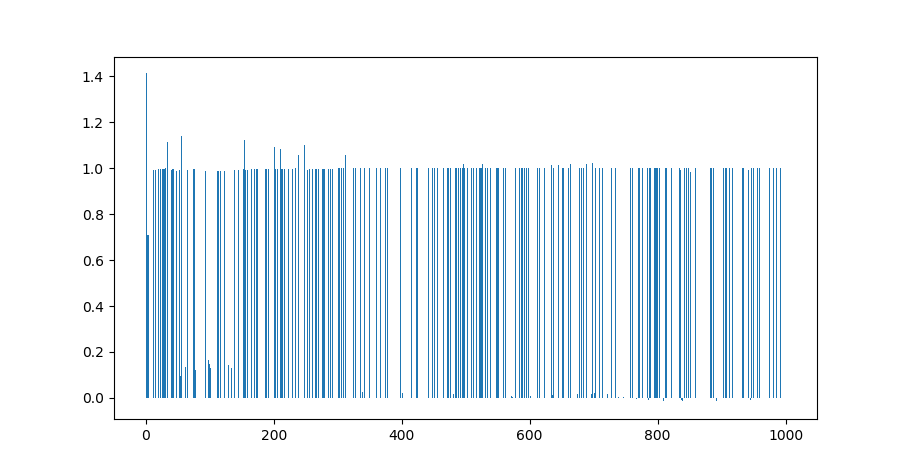

<BarContainer object of 1000 artists>

In [76]:
%matplotlib notebook
import matplotlib.pyplot as plt
plt.bar(np.arange(0, 1000), wrapper_1.r_buffer.T.flatten())

In this example r is sqrt(2) or 1/sqrt(2) or 0. Need to scale to -1, 0 and 1 > (r - 0.7ish)/0.7ish

In [77]:
wrapper_1.r_buffer.T.flatten()

array([ 0.        ,  1.41421356,  0.70710678,  0.70710678,  0.70710678,
        0.        ,  0.        ,  0.        ,  0.98458396,  0.        ,
        0.        ,  0.        ,  0.99050294,  0.        ,  0.        ,
        0.99371109,  0.        ,  0.        ,  0.        ,  0.        ,
        0.99530891,  0.        ,  0.        ,  0.99652643,  0.        ,
        0.        ,  0.99732988,  0.        ,  0.99792773,  0.99839091,
        0.99873082,  0.998986  ,  0.        ,  0.9991507 ,  1.11608694,
        0.        ,  0.99314647,  0.        ,  0.        ,  0.        ,
        0.99408325,  0.        ,  0.99484536,  0.99548258,  1.14664086,
        0.        ,  0.98821427,  0.        ,  0.98949948,  0.99054721,
        0.        ,  0.        ,  0.        ,  0.99156123,  0.09678363,
        0.        ,  1.13824055,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.13368794,  0.9924994 ,  0.        ,
        0.99340765,  0.        ,  0.        ,  0.        ,  0.99

In [117]:
wrapper_1.r_buffer.T*(np.sqrt(2)/2)

array([[ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [-0.70710678],
       [-0.70710678],
       [ 0.        ],
       [ 0.        ],
       [ 0.10511372],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0

In [78]:
wrapper_2.r_buffer.T.flatten()

array([ 0.        ,  0.        , -1.        , -1.40435928, -0.72317655,
        0.        ,  0.        ,  0.        , -0.7977784 ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
       -0.93936567,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        , -0.97399705,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.98453407,
        0.        , -0.99094913,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.99296496,
        0.        ,  0.        ,  0.        , -0.12485316,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  1.25148418,
        0.        ,  0.9606586 ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.96941533,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        , -0.97

For wrapper_2 we have -sqrt(2), -1/sqrt(2), 0, sqrt(2) and +sqrt(2). This suggests probabilities - but do we need to scale first?

Also note the increase in 0s.

**What happens when we reconstruct with binary signals and not the values above?** We would need to apply the same scaling to the eigenvector.

In [79]:
print(wrapper_1.vpu.pi.eigenvector, wrapper_1.vpu.pi.eigenvalue, wrapper_1.vpu.cu.mean, sep="\n", end="\n\n")
print(np.dot(wrapper_1.vpu.pi.eigenvector, np.sqrt(wrapper_1.vpu.pi.eigenvalue))+wrapper_1.vpu.cu.mean)

[[-0.99993339]
 [-0.01154203]]
[[0.22634084]]
[[-0.356]
 [ 0.11 ]]

[[-0.83172122]
 [ 0.10450885]]


In [80]:
print(np.dot(wrapper_1.vpu.pi.eigenvector, np.sqrt(wrapper_1.vpu.pi.eigenvalue)))

[[-0.47572122]
 [-0.00549115]]


Is the "feature" here then [-1, 1] and we need to scale and add the mean to get the feature (or then feature / feature.max?).

In [81]:
print(wrapper_1.vpu.pi.eigenvector, np.abs(wrapper_1.vpu.pi.eigenvector).max())

[[-0.99993339]
 [-0.01154203]] 0.9999333885531576


In [82]:
wrapper_1.vpu.pi.eigenvector / np.abs(wrapper_1.vpu.pi.eigenvector).max()

array([[-1.       ],
       [-0.0115428]])

In [83]:
wrapper_2.vpu.pi.eigenvector / np.abs(wrapper_2.vpu.pi.eigenvector).max()

array([[0.03743114],
       [1.        ]])

**Divide by the largest value in the eigenvector then use the result as a probability?**

We only need to apply the PBT on the output.

**What about normalising the residual?**

The maximum distance in the space is 2 - -1 to 1. There is thus the chance for binary overflow -1 - (-1).

So the plan is:
* We normalise the eigenvector by dividing by the max entry (of the abs).
* We apply normalising and PBT to the r output.
* We normalise the residual (at the switch).

It would be good to do this and see if we get similar results to the test above.

In [84]:
print(wrapper_2.vpu.pi.eigenvector, wrapper_2.vpu.pi.eigenvalue, wrapper_2.vpu.cu.mean, sep="\n", end="\n\n")
print(np.dot(wrapper_2.vpu.pi.eigenvector, np.sqrt(wrapper_2.vpu.pi.eigenvalue))+wrapper_2.vpu.cu.mean)

[[0.03740495]
 [0.99930019]]
[[0.11178323]]
[[-0.002]
 [ 0.092]]

[[0.01050597]
 [0.42610602]]


When scaled does this relate to the Hadamard matrix - [-1, 1] and [1, 1]?

The variations from 1 indicate the patterns in the input (they are based on a data_in of [60, 190]).

In [85]:
 mean = np.asarray([128,128]).reshape(-1, 1); print(mean)

[[128]
 [128]]


In [86]:
ternary_input.dtype

dtype('int64')

In [87]:
pred.dtype; print(pred)

[[0.]
 [0.]]


In [88]:
residual.dtype; print(residual)

[[0]
 [0]]


In [89]:
np.asarray([[0,  1]])-np.asarray([[-0.,  1.]])

array([[0., 0.]])

In [90]:
wrapper_1.residual_buffer.max()

1.0

In [91]:
wrapper_1.residual_buffer.min()

-1.0

Is the accuracy associated with the lack of the -2 or 2 residuals? These tend to make it go haywire.

Do we clamp or normalise and PBT?

In [92]:
print(f"Max wrapper 2 residual: {wrapper_2.residual_buffer.max()}; min wrapper 2 residual: {wrapper_2.residual_buffer.min()}")

Max wrapper 2 residual: 1.0; min wrapper 2 residual: -1.0


In [93]:
print(vpu.cu.mean)

[[-0.07133333]
 [ 0.24133333]]


Because we have a static value the CU mean is biased based on the static value. So we can ignore here - in real life we have variation so this should tend to 0 > need to check. If it is not 0 in real like we would need to constantly adapt such that it is 0.

In [94]:
print(np.sqrt(vpu.pi.eigenvalue))

[[0.65593642]]


In [95]:
from src.tests.vpu_wrapper import VPUWrapper

"""Use the VPU Wrapper to test advanced function."""
# Initialise two VPUs and wrappers
data_in = np.random.randint(255, size=(2, 1))
mean = np.asarray([128, 128]).reshape(-1, 1)
vpu_1 = VPU(2)
vpu_2 = VPU(2)
wrapper_1 = VPUWrapper(vpu_1)
wrapper_2 = VPUWrapper(vpu_2)
for _ in range(0, 1000):
    # First VPU
    ternary_input = signal_pre_processor(data_in, mean)
    _, _, residual = wrapper_1.iterate(ternary_input)
    # Second VPU
    _ = wrapper_2.iterate(residual)
est = (wrapper_1.pred_estimate*mean+mean)+(wrapper_2.pred_estimate*mean)
assert np.allclose(data_in, est, rtol=0.10, atol=10)
print(data_in, est)

[[126]
 [126]] [[126.05537034]
 [126.4270166 ]]


### Signal Scaling

We have a number of options. We need scaling because:
* The maximum residual = 2\*max and the minimal residual = 2\*min. This will be 2x regardless of the length as we are only subtracting two values.
* The "unit length" eigenvalue is unit length in the zero mean, -1 to 1 space. This is actually sqrt(2) for 2D space, is sqrt(3) for 3D space and will be generally sqrt(L) where L is the segment length. We will also have both +ve and -ve values - so range is -sqrt(L) to sqrt(L).
    * So we could divide our output by the unit length to get in -1 to 1.

#### Ternary Signal Reconstruction

When we generate the signal:
* We subtract the mean - **m** from the signal_max.
* We compare +ve values with 0 to (signal_max-**m**).
* We take the absolute of -ve values and compare with 0 to **m**.
* Zeroes we just keep as zeros.

To reconstruct:
* We need to sum +ve and -ve values separately.
* We then reconstruct as m + (signal_max-m) x average(+ve values) - m x average(-ve values).

For the residuals:
* We have min residual = -2, max residual = 2 and zero mean. 
* For reconstruction we thus have 0 + (2) x average(+ve values) - (-2) x average(-ve values) > 2 x average of all values.

In [96]:
from src.var_processor.power_iterator import PowerIterator

In [97]:
def init_power(size):
    """Helper function."""
    # Test with length = size
    cov = np.random.randn(size, size)
    cov = np.dot(cov, cov.T)
    cov = cov / cov.max()
    # Generate test power iterator
    power = PowerIterator(size)
    power.load_covariance(cov)
    for _ in range(0, 1000):
        power.iterate()
    return power, cov

In [98]:
power, cov = init_power(3)

In [99]:
power.ev

array([[-0.18494919],
       [-0.20493957],
       [ 0.96114181]])

In [100]:
power.ev

array([[-0.18494919],
       [-0.20493957],
       [ 0.96114181]])

In [101]:
power.eigenvector

array([[-0.18494919],
       [-0.20493957],
       [ 0.96114181]])

In [102]:
power.feature

array([[-0.10678046],
       [-0.11832192],
       [ 0.55491548]])

In [103]:
power.feature*np.sqrt(3)

array([[-0.18494919],
       [-0.20493957],
       [ 0.96114181]])

In [104]:
power.iterate()

array([[-0.18494919],
       [-0.20493957],
       [ 0.96114181]])

In [105]:
power.feature.sum()

0.32981310142538645

In [106]:
print(wrapper_1.vpu.pi.feature, wrapper_2.vpu.pi.feature, sep="\n")

[[ 0.70623218]
 [-0.0351583 ]]
[[0.12456005]
 [0.69604942]]


When we change ev to feature we get worse estimate on the first test - but this is because we are not taking prob of r?

In [107]:
power.eigenvector*np.sqrt(3)

array([[-0.32034139],
       [-0.35496575],
       [ 1.66474644]])